In [1]:
import os
import time
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import torch
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold
from category_encoders import TargetEncoder, OneHotEncoder
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from math import sqrt
from datetime import datetime

In [2]:
from src.utils import check_stationarity, get_scaler, get_sample_weight, load_word2vec_embeddings, get_torch_optimizer, dummy_lagged_df, get_torch_criterion
from src.arima import grid_search_arima
from src.sarimax import grid_search_sarimax
from src.ml_model import grid_search_ml, get_model, one_step_prediction as one_step_ml_prediction
from src.rnn import train_rnn, eval_rnn, one_step_prediction, grid_search_rnn, TimeSeriesDataset, ForecastModel

# Forecasting Visitor Arrivals
Precovid Sanity Test

## Baseline of simple SARIMA 

In [3]:
country_list = ['Canada', 'Chile', 'Mexico', 'Chinese Taipei', 'Hong Kong SAR', 'Japan', 
                'Korea (ROK)', 'Macao, China', 'Maldives', 'Cambodia', 'Indonesia', 'Singapore', 
                'New Zealand', 'USA', 'Thailand', 'Turkey', 'Australia', 'Hawaii', 'Austria', 'Czech']

imputed_dir = './data/imputed/'

In [4]:
aus_df = pd.read_csv(os.path.join(imputed_dir, 'Chile.csv'))
aus_df['Date'] = pd.to_datetime(aus_df['Date'])
aus_df = aus_df[aus_df['Date'] < '2020-01-01']
aus_df = aus_df.set_index('Date')

In [5]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'

train_df = aus_df[[target] + candidates]
train_df = train_df.loc[train_df[target].first_valid_index(): train_df[target].last_valid_index()]
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [6]:
len(test_y) / (len(train_y) + len(test_y))

0.125

In [7]:
test_y

Date
2019-01-01    3234.0
2019-02-01    3790.0
2019-03-01    4025.0
2019-04-01    3136.0
2019-05-01    2930.0
2019-06-01    2248.0
2019-07-01    2105.0
2019-08-01    2247.0
2019-09-01    2817.0
2019-10-01    2994.0
2019-11-01    2967.0
2019-12-01    3677.0
Name: VisitorArrivals, dtype: float64

/scratch/zt00296/Projects/tourism-forecasting/src/utils.py:45: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The series isn't stationary


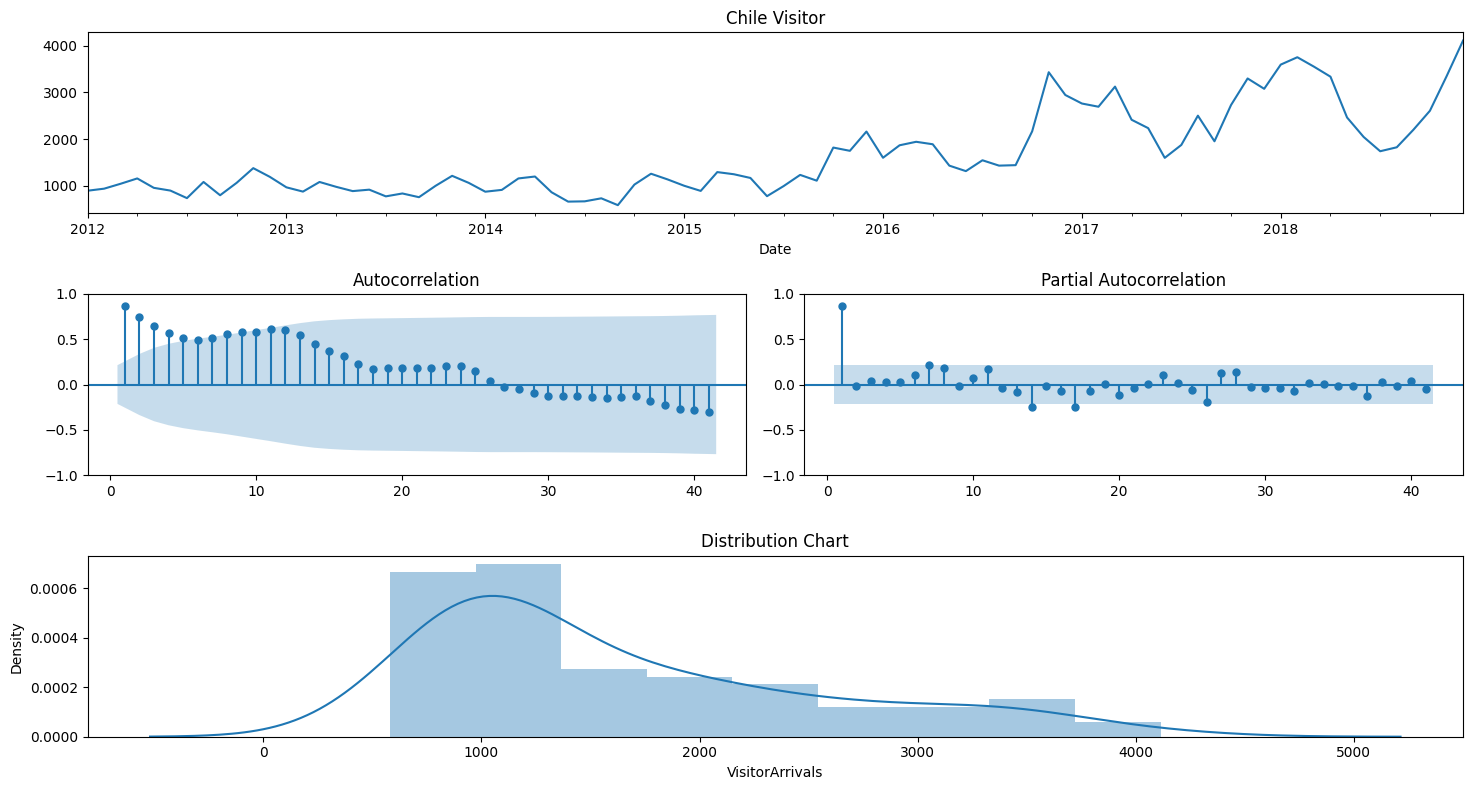

In [8]:
# find parameter analytically
check_stationarity(train_y.dropna(), title='Chile Visitor')

/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 1), (1, 1, 1, 12), 'c'] 217.3311604829874


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RMSE: 392.1335606855485
R2 0.5582362967606294


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

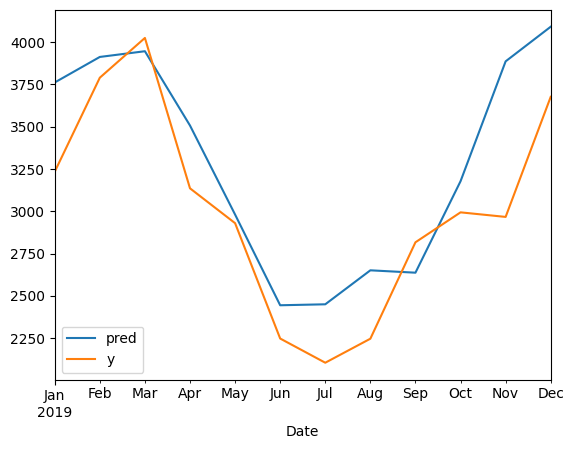

In [ ]:
best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True)
print(best_param, best_rmse)
sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
result = sarima_model.fit(disp=False)
pred = result.forecast(len(test_y))
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [10]:
# repeat for chile and maldives
sarima_pred, all_y = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        train_y = df[target]
        train_y = train_y.loc[train_y.first_valid_index(): train_y.last_valid_index()]
        train_y, test_y = train_y.iloc[:-1*12], train_y.iloc[-1*12:]
        best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True, init_repeat=False)
        print(best_param, best_rmse, best_r2)
        sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
        result = sarima_model.fit(disp=False)
        pred = result.forecast(len(test_y))
        sarima_pred.append(pred)
        all_y.append(test_y)
sarima_pred, all_y = pd.concat(sarima_pred).values, pd.concat(all_y).values

processing Japan.csv
[(3, 1, 1), (1, 1, 0, 12), 'n'] 64082.61819999945 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Korea (ROK).csv
[(3, 0, 1), (1, 1, 1, 12), 'n'] 112466.80960032636 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Chile.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 1), (1, 1, 1, 12), 'c'] 217.3311604829874 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


processing Maldives.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(2, 0, 1), (1, 0, 0, 12), 'c'] 2135.6353667821645 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt

processing Cambodia.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(1, 0, 1), (1, 0, 0, 12), 'n'] 8926.931088850528 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/scra

processing Singapore.csv
[(2, 1, 1), (1, 1, 1, 12), 'n'] 27591.206389474246 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing USA.csv
[(3, 0, 1), (1, 1, 1, 12), 'n'] 23864.209598652174 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Chinese Taipei.csv
[(1, 0, 0), (0, 0, 0, 12), 'c'] 48600.04210384344 None
processing Thailand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(3, 0, 1), (1, 1, 1, 12), 'n'] 118227.04999892694 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Indonesia.csv
[(2, 1, 1), (1, 0, 1, 12), 'c'] 25348.54108412533 None
processing Turkey.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/

[(3, 1, 1), (0, 0, 0, 12), 'c'] 5113.065125016372 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


processing Macao, China.csv
[(3, 0, 1), (0, 1, 1, 12), 'c'] 145050.2880355367 None
processing Australia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)


[(2, 0, 0), (1, 0, 1, 12), 'n'] 9359.174841198283 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


processing New Zealand.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(2, 0, 0), (1, 0, 1, 12), 'n'] 3028.243313058678 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


processing Czech.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)


[(3, 0, 1), (0, 1, 1, 12), 'c'] 8654.86865123542 None
processing Hawaii.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/

[(3, 0, 1), (0, 0, 1, 12), 'n'] 1846.21913602951 None
processing Mexico.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 1), (1, 0, 1, 12), 'c'] 1328.087132324264 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


processing Hong Kong SAR.csv
[(1, 0, 0), (0, 1, 1, 12), 'n'] 620351.6216687443 None
processing Canada.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/

[(2, 0, 1), (1, 0, 1, 12), 'n'] 3826.7434952984636 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


processing Austria.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(1, 0, 1), (0, 1, 1, 12), 'c'] 5456.119282166938 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


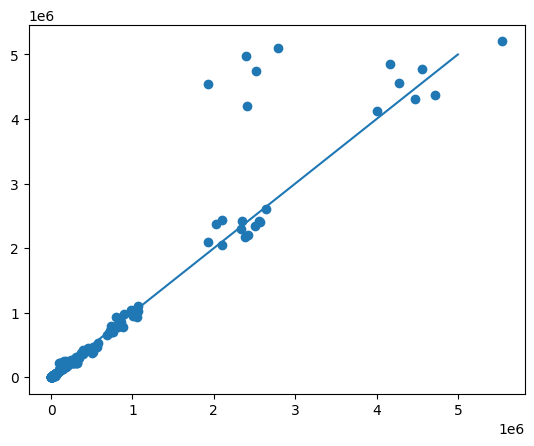

In [13]:
plt.scatter(all_y, sarima_pred)
plt.plot((0, 5000000), (0, 5000000))

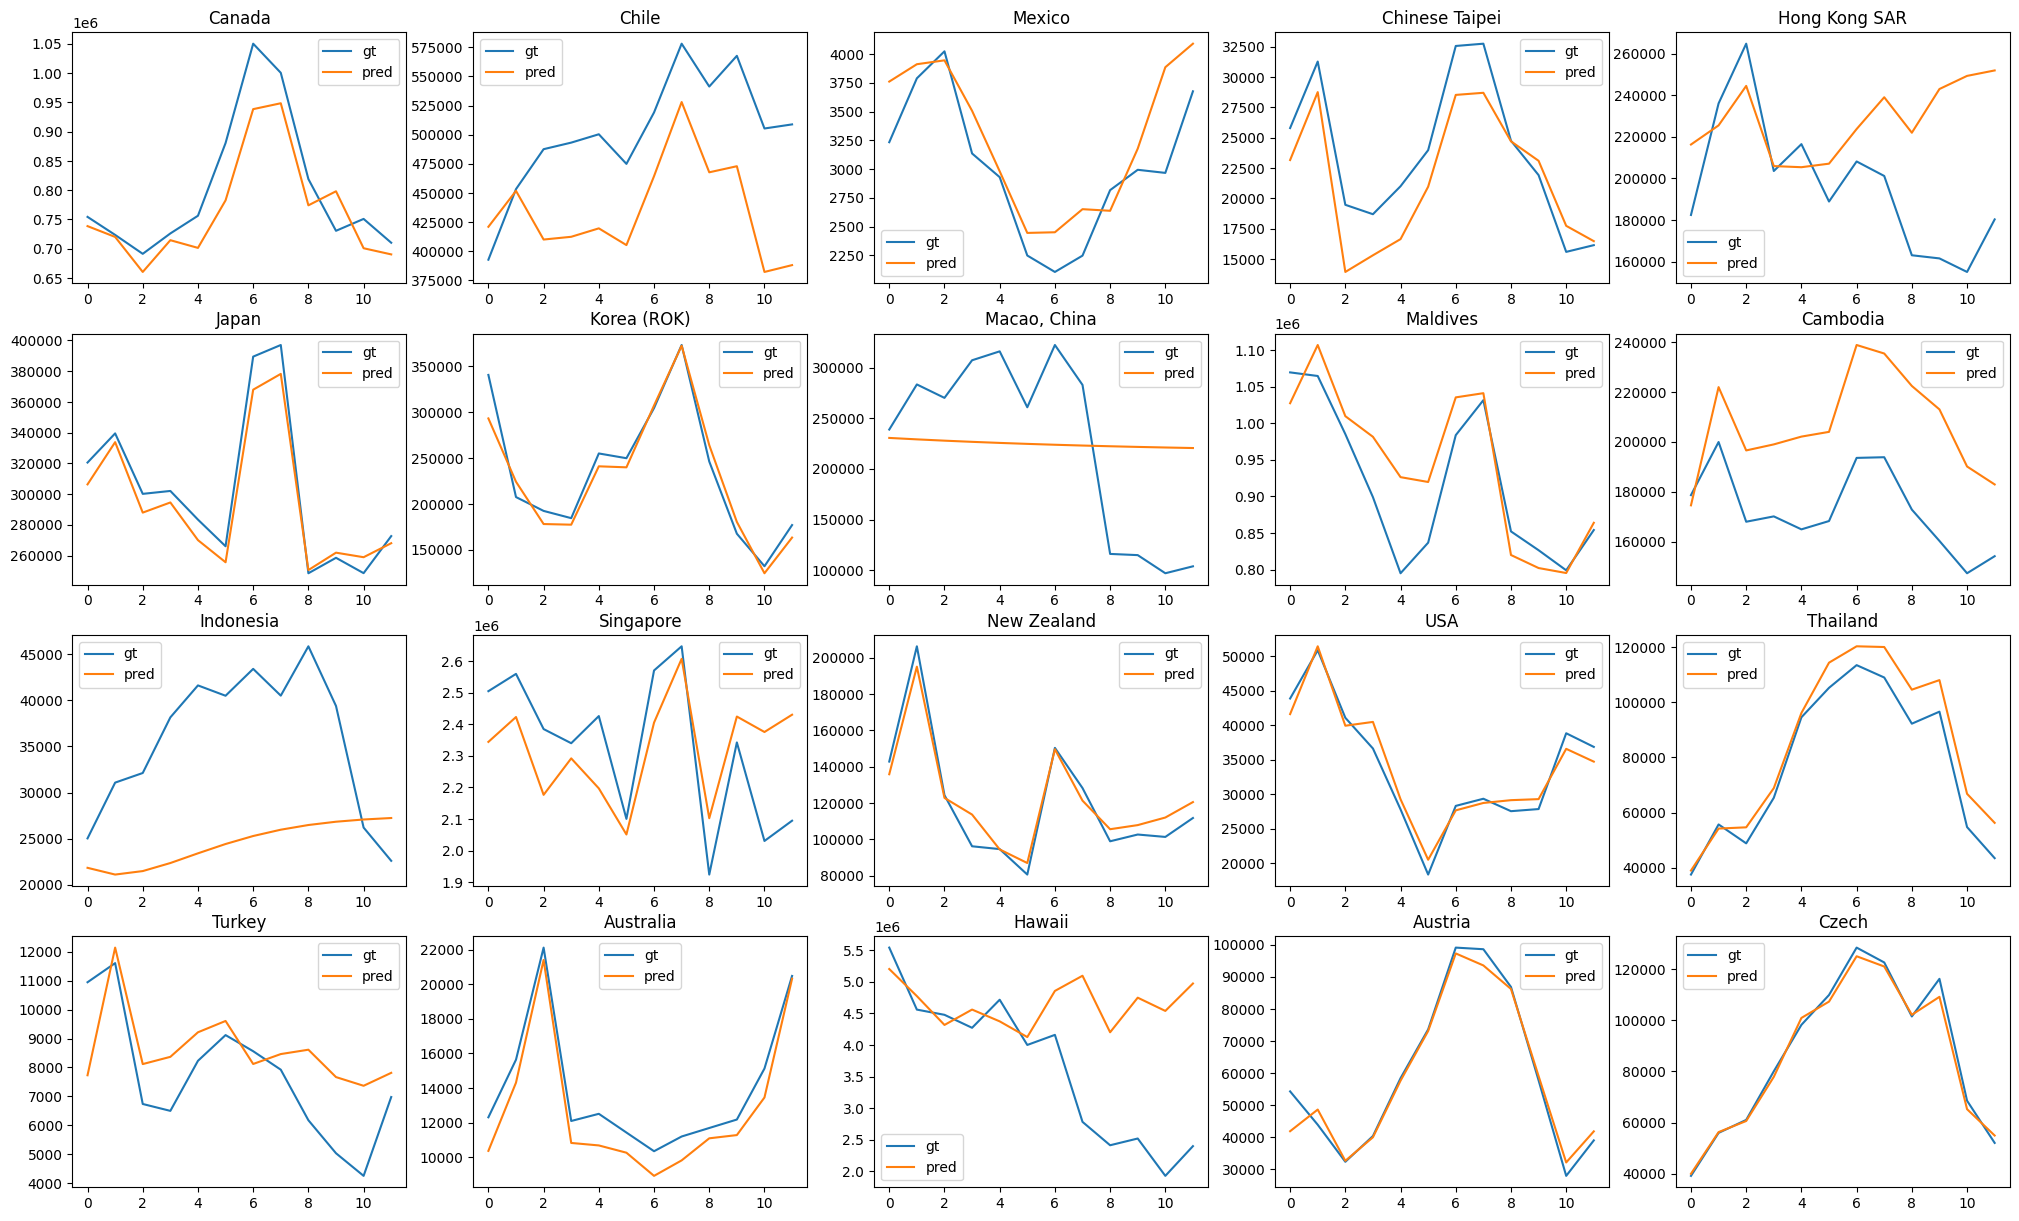

In [16]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(sarima_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [12]:
baseline_rmse = sqrt(mean_squared_error(all_y, sarima_pred))
baseline_r2 = r2_score(all_y, sarima_pred)
baseline_mae = mean_absolute_error(all_y, sarima_pred)
baseline_mape = mean_absolute_percentage_error(all_y, sarima_pred)
print(f'Baseline SARIMA RMSE: {baseline_rmse:.5f}\nBaseline SARIMA R2: {baseline_r2:.5f}\nBaseline SARIMA MAE: {baseline_mae:.5f}\nBaseline SARIMA MAPE: {baseline_mape:.5f}')

Baseline SARIMA RMSE: 345304.93019
Baseline SARIMA R2: 0.86231
Baseline SARIMA MAE: 84056.92734
Baseline SARIMA MAPE: 0.14773


# Preprocessing Data

In [4]:
target = 'VisitorArrivals'
candidates = ['FXAgainstChina', 'CovidCases', 'CovidDeaths', 'FSI',
               'GDPPerCap', 'GDP', 'Population',
               'TravelPolicy', 'Temperature', 'Precipitation', 'GlobalCovidTrend',
               'DistFromChina', 'Country', 'GDPRatioChina',
               'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
               'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
               'ChinaGDP']
def load_data(country='Japan', csv_dir='./data/imputed', log_transform=True, dropna=True, remove_covid=False):
    df = pd.read_csv(os.path.join(csv_dir, f'{country}.csv'))
    if dropna:
        df = df.iloc[df['VisitorArrivals'].first_valid_index():].reset_index(drop=True)
    if log_transform:
        df['VisitorArrivals'] = np.log1p(df['VisitorArrivals'])
    df['Date'] = pd.to_datetime(df['Date'])
    if remove_covid:
        df = df[df['Date'] < ('2019-07-01' if country in ['Hong Kong SAR', 'Chinese Taipei'] else '2020-01-01')]
    df = df.set_index('Date').asfreq('MS')
    return df[candidates + [target]]

In [5]:
df = load_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 1997-01-01 to 2019-12-01
Freq: MS
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FXAgainstChina            276 non-null    float64
 1   CovidCases                276 non-null    float64
 2   CovidDeaths               276 non-null    float64
 3   FSI                       276 non-null    float64
 4   GDPPerCap                 276 non-null    float64
 5   GDP                       276 non-null    float64
 6   Population                276 non-null    float64
 7   TravelPolicy              276 non-null    float64
 8   Temperature               276 non-null    float64
 9   Precipitation             276 non-null    float64
 10  GlobalCovidTrend          276 non-null    float64
 11  DistFromChina             276 non-null    float64
 12  Country                   276 non-null    object 
 13  GDPRatioChina             276 non-nul

<Axes: >

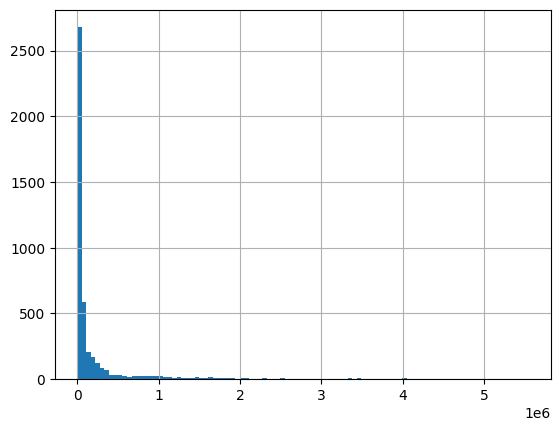

In [6]:
pd.concat([load_data(country, log_transform=False)['VisitorArrivals'] for country in country_list], ignore_index=True).hist(bins=100)

<Axes: >

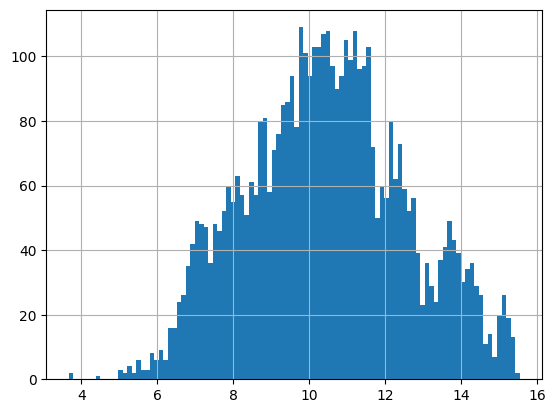

In [7]:
pd.concat([load_data(country, log_transform=True)['VisitorArrivals'] for country in country_list], ignore_index=True).hist(bins=100)

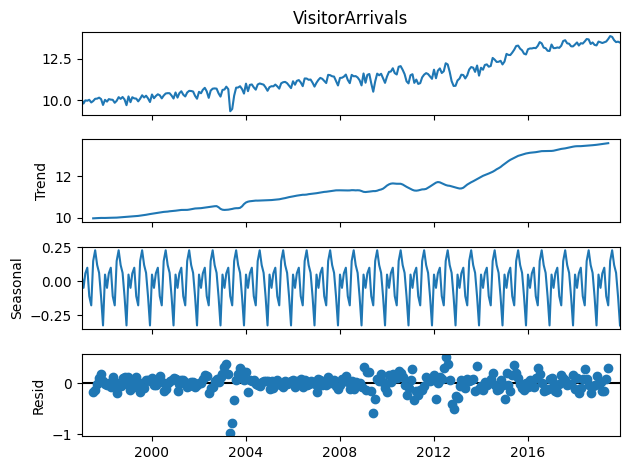

In [8]:
res = seasonal_decompose(df[df.index < '2020-01-01']['VisitorArrivals'], period=12)
fig = res.plot()

<Axes: xlabel='Date'>

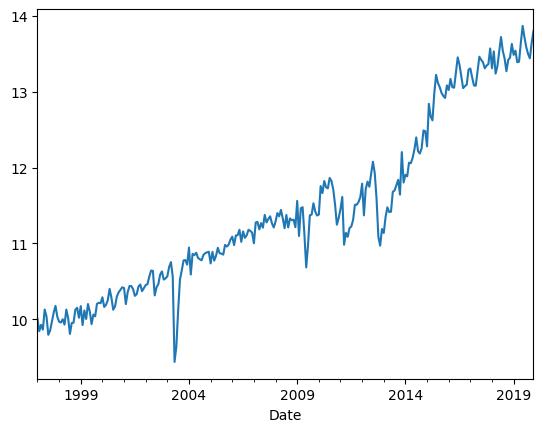

In [9]:
seasonal_component = pd.concat([res.seasonal, pd.Series(np.resize(res.seasonal.values[-12:], len(df['VisitorArrivals'].dropna()) - len(res.seasonal)))], ignore_index=True)
seasonal_component.index = df['VisitorArrivals'].dropna().index
(df['VisitorArrivals'].dropna() - seasonal_component).plot()

In [10]:
def get_seasonal_component(seasonal_res, target_length):
    if len(seasonal_res.seasonal) >= target_length:
        return seasonal_res.seasonal.iloc[:target_length]
    seasonal_component = pd.concat([seasonal_res.seasonal, pd.Series(np.resize(seasonal_res.seasonal.values[-12:], target_length - len(seasonal_res.seasonal)))], ignore_index=True)
    return seasonal_component

#load all data and decomposed precovid seasonality
def load_and_preprocess_all(test_size=0, deduct_seasonality=True, single_x_scaler=False, single_y_scaler=False, scaler_type='standard', remove_covid=False):
    all_data = {country: load_data(country) for country in country_list}
    all_decomposed_seasonal = {country: seasonal_decompose(df[df.index < '2020-01-01']['VisitorArrivals'], period=12) for country, df in all_data.items()}
    
    x_scaler, y_scaler = {}, {}
    #some feature engineering and processing
    for country in country_list:
        all_data[country]['Popularity'] = all_data[country]['VisitorArrivals'].median()
        all_data[country]['Unrest'] = 0.
        all_data[country]['TravelRestriction'] = (all_data[country][['TravelPolicy', 'ChinaConfinementPolicy', 'ChinaMovementPolicy']] > 0).all(axis=1).astype(int)
        
        all_data[country]['Year'] = all_data[country].index.year
        all_data[country]['MonthSin'] = np.sin(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        all_data[country]['MonthCos'] = np.cos(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        
        if deduct_seasonality:
            # remove seasonality
            seasonal_component = get_seasonal_component(all_decomposed_seasonal[country], len(all_data[country]))
            assert len(seasonal_component) == len(all_data[country])
            seasonal_component.index = all_data[country].index
            all_data[country]['VisitorArrivals'] -= seasonal_component
            
        # 1. taiwan ban china starting september 2019 - january 2024 election
        # 2. hong kong protest starting august 2019 end mid 2020
        # 3. china ban korea starting march 2017 - nov 2017
        # 4. singapore and thailand april 2014 - jan 2015
        # 5. sars world april 2003 - july 2003
        # 6. hawaii and USA trump presidential between november 2016 to january 2021
        # 7. turkey coup 2016
        if country == 'Chinese Taipei':
            all_data[country].loc[(all_data[country].index >= '2019-09-01') & (all_data[country].index <= '2024-02-01'), 'TravelRestriction'] = 1
        elif country == 'Hong Kong SAR':
            all_data[country].loc[(all_data[country].index >= '2019-08-01') & (all_data[country].index <= '2020-06-01'), 'Unrest'] = 1.
        elif country == 'Korea (ROK)':
            all_data[country].loc[(all_data[country].index >= '2017-03-01') & (all_data[country].index <= '2017-11-01'), 'TravelRestriction'] = 1
        elif country in ['Singapore', 'Thailand']:
            all_data[country].loc[(all_data[country].index >= '2014-04-01') & (all_data[country].index <= '2015-01-01'), 'Unrest'] = 1.
        elif country in ['Hawaii', 'USA']:
            all_data[country].loc[(all_data[country].index >= '2016-11-01') & (all_data[country].index <= '2021-01-01'), 'Unrest'] = 0.5
        elif country == 'Turkey':
            all_data[country].loc[(all_data[country].index >= '2015-12-01') & (all_data[country].index <= '2017-02-01'), 'Unrest'] = 1.
            
        all_data[country].loc[(all_data[country].index >= '2003-04-01') & (all_data[country].index <= '2003-07-01'), 'Unrest'] = 1. # SARS

        # assume covid case and deaths exponentially reduce
        for c in ['CovidCases', 'CovidDeaths']:
            all_data[country][c] = all_data[country][c].fillna(all_data[country][c].ffill()[all_data[country][c].isnull()].mul((1/2)**(all_data[country][c].groupby(all_data[country][c].notnull().cumsum()).cumcount()), 0)).round()
    
    country_feat = ['GDPPerCap', 'GDP', 'Population', 'CovidCases', 'CovidDeaths', 
                    'Temperature', 'Precipitation',]  # only normalize country specific features, other features are universal which will be normalize separately
    if single_x_scaler:
        temp_df = pd.concat([all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)  # only fit on train that is valid
        x_scaler = get_scaler(scaler_type)
        x_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][country_feat] = x_scaler.transform(all_data[country][country_feat])
    else:
        for country in country_list:
            country_x_scaler = get_scaler(scaler_type)
            country_x_scaler.fit(all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][country_feat] = country_x_scaler.transform(all_data[country][country_feat])
            x_scaler[country] = country_x_scaler
    
    universal_feat = ['FXAgainstChina', 'FSI', 'Year', 'MonthSin', 'MonthCos', 'Unrest',
                       'TravelPolicy', 'GlobalCovidTrend',
                       'DistFromChina', 'GDPRatioChina',
                       'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                       'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                       'ChinaGDP', 'Popularity', 'TravelRestriction']
    universal_x_scaler = get_scaler(scaler_type)
    temp_df = pd.concat([all_data[country][universal_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)
    universal_x_scaler.fit(temp_df)
    for country in country_list:
        all_data[country][universal_feat] = universal_x_scaler.transform(all_data[country][universal_feat])
        
    if single_y_scaler:
        temp_df = pd.concat([all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True) # only fit on train
        y_scaler = get_scaler(scaler_type)
        y_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][[target]] = y_scaler.transform(all_data[country][[target]])
    else:
        for country in country_list:
            country_y_scaler = get_scaler(scaler_type)
            country_y_scaler.fit(all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][[target]] = country_y_scaler.transform(all_data[country][[target]])
            y_scaler[country] = country_y_scaler
    
    return all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler

def inverse_target(target, seasonal_component, scaler):
    target = np.asarray(target)
    if target.ndim == 1:
        target = np.expand_dims(target, -1)
    return np.expm1(scaler.inverse_transform(target).flatten() + seasonal_component)

In [359]:
deduct_seasonality = True
single_x_scaler = False
single_y_scaler = False
all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler = load_and_preprocess_all(test_size=12, deduct_seasonality=deduct_seasonality, single_x_scaler=single_x_scaler, single_y_scaler=single_y_scaler, remove_covid=True)

<Axes: xlabel='Date'>

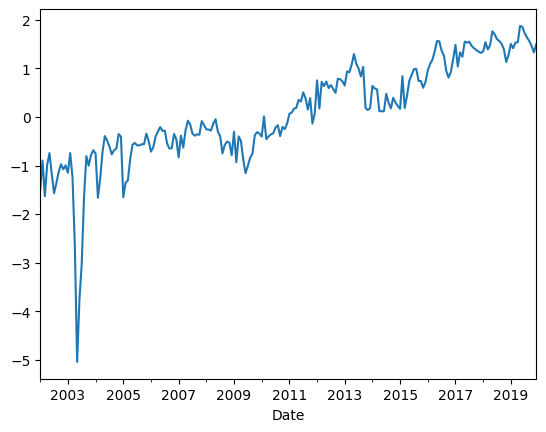

In [360]:
country = 'Singapore'
all_data[country]['VisitorArrivals'].plot()

In [361]:
all_data[country]

FXAgainstChina  CovidCases  CovidDeaths       FSI  GDPPerCap  \
Date                                                                       
2002-01-01       -0.259286         0.0          0.0 -0.755086  -1.933853   
2002-02-01       -0.259289         0.0          0.0 -0.755086  -1.910476   
2002-03-01       -0.259290         0.0          0.0 -0.755086  -1.887099   
2002-04-01       -0.259291         0.0          0.0 -0.755086  -1.863722   
2002-05-01       -0.259302         0.0          0.0 -0.755086  -1.840345   
...                    ...         ...          ...       ...        ...   
2019-08-01       -0.259379         0.0          0.0 -0.998266   1.426329   
2019-09-01       -0.259387         0.0          0.0 -0.998266   1.400218   
2019-10-01       -0.259390         0.0          0.0 -0.998266   1.374108   
2019-11-01       -0.259387         0.0          0.0 -0.998266   1.347998   
2019-12-01       -0.259389         0.0          0.0 -0.998266   1.321888   

                 GDP  Population  TravelPolicy  Temperature  Precipitation  \
Date                                                                         
2002-01-01 -1.681899   -1.598512           0.0    -0.877961      -0.362024   
2002-02-01 -1.669684   -1.594969           0.0    -0.050308      -1.490460   
2002-03-01 -1.657470   -1.591424           0.0     1.108406      -0.913265   
2002-04-01 -1.645255   -1.587880           0.0     1.439467      -0.329842   
2002-05-01 -1.633041   -1.584336           0.0     1.936058      -0.115989   
...              ...         ...           ...          ...            ...   
2019-08-01  1.490276    1.360326           0.0     0.942875      -1.415715   
2019-09-01  1.476286    1.366896           0.0     0.611814      -1.567281   
2019-10-01  1.462296    1.373464           0.0    -0.050308      -0.212535   
2019-11-01  1.448305    1.380032           0.0    -0.215839      -0.373443   
2019-12-01  1.434315    1.386601           0.0    -1.209022       1.519049   

            ...  ChinaMovementPolicy  ChinaGDPPerCap  ChinaGDP  \
Date        ...                                                  
2002-01-01  ...                  0.0       -1.128570 -1.118569   
2002-02-01  ...                  0.0       -1.120902 -1.111231   
2002-03-01  ...                  0.0       -1.113234 -1.103893   
2002-04-01  ...                  0.0       -1.105566 -1.096555   
2002-05-01  ...                  0.0       -1.097899 -1.089217   
...         ...                  ...             ...       ...   
2019-08-01  ...                  0.0        1.836772  1.884743   
2019-09-01  ...                  0.0        1.843585  1.892684   
2019-10-01  ...                  0.0        1.850399  1.900625   
2019-11-01  ...                  0.0        1.857213  1.908566   
2019-12-01  ...                  0.0        1.864027  1.916507   

            VisitorArrivals  Popularity   Unrest  TravelRestriction      Year  \
Date                                                                            
2002-01-01        -1.501527    0.669625 -0.18031          -0.045937 -0.935167   
2002-02-01        -0.896859    0.669625 -0.18031          -0.045937 -0.935167   
2002-03-01        -1.631448    0.669625 -0.18031          -0.045937 -0.935167   
2002-04-01        -0.986685    0.669625 -0.18031          -0.045937 -0.935167   
2002-05-01        -0.743344    0.669625 -0.18031          -0.045937 -0.935167   
...                     ...         ...      ...                ...       ...   
2019-08-01         1.635874    0.669625 -0.18031          -0.045937  1.573967   
2019-09-01         1.564336    0.669625 -0.18031          -0.045937  1.573967   
2019-10-01         1.462316    0.669625 -0.18031          -0.045937  1.573967   
2019-11-01         1.330468    0.669625 -0.18031          -0.045937  1.573967   
2019-12-01         1.498101    0.669625 -0.18031          -0.045937  1.573967   

            MonthSin  MonthCos  
Date                            
2002-01-01 -0.000452  1.41466

In [362]:
# longest input sequence
np.unique([df['VisitorArrivals'].notna().sum() for country, df in all_data.items()], return_counts=True)

(array([ 84,  96, 132, 180, 200, 204, 216, 240, 246, 252, 264, 276, 288,
        300, 372]),
 array([1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2]))

In [363]:
# longest required forecast is 18 months
np.unique([df['VisitorArrivals'].isna().sum() for country, df in all_data.items()], return_counts=True)

(array([0]), array([20]))

## Regression

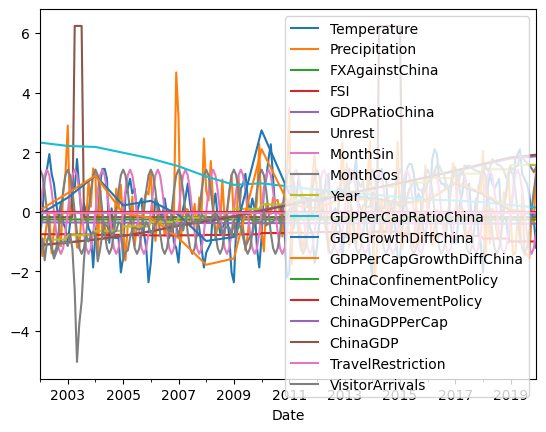

Pearson: 0.13168831000374417
Kendall: 0.12348292900969479
Spearman: 0.17840523824690488


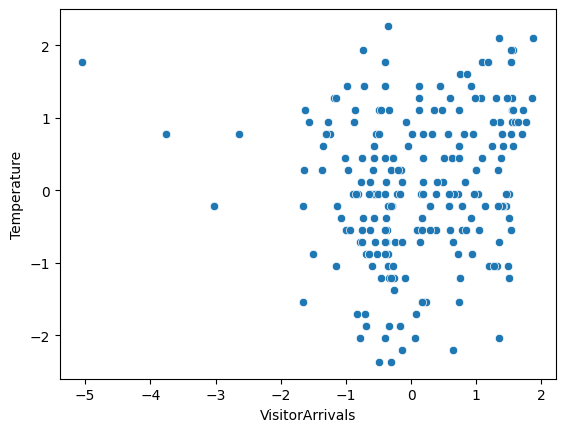

Pearson: -0.02526419132044302
Kendall: -0.02588787712048014
Spearman: -0.042343437374655235


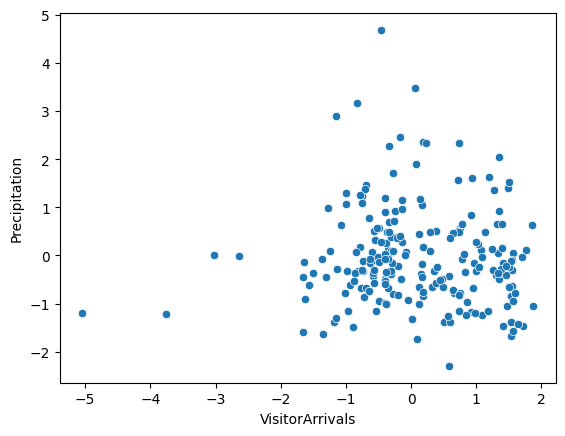

Pearson: -0.21719899186341404
Kendall: -0.16210163652024115
Spearman: -0.22529203729503802


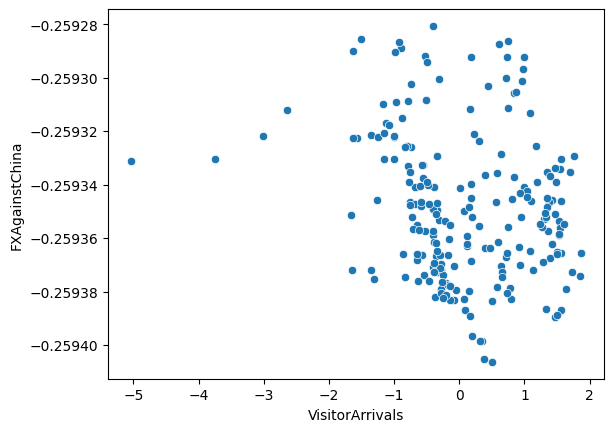

Pearson: -0.35771937195464454
Kendall: -0.1596059702981034
Spearman: -0.23227135670736204


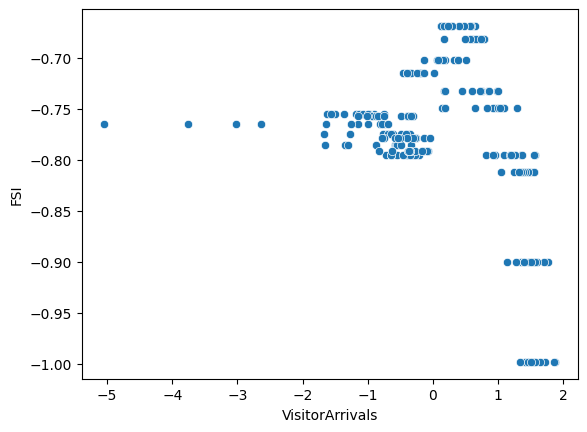

Pearson: -0.8539447518341833
Kendall: -0.7545219638242893
Spearman: -0.9217471034425272


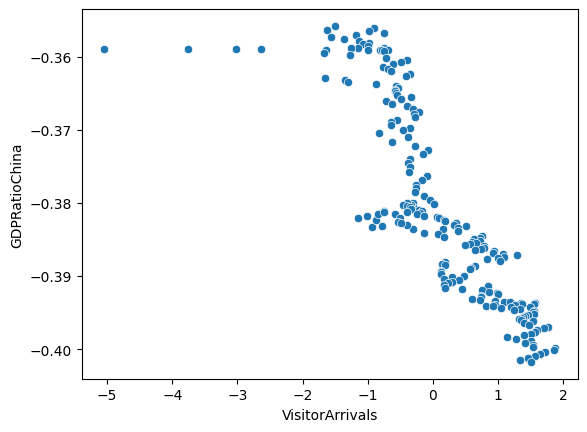

Pearson: -0.24095972309554162
Kendall: -0.06885942449248422
Spearman: -0.08414068180540754


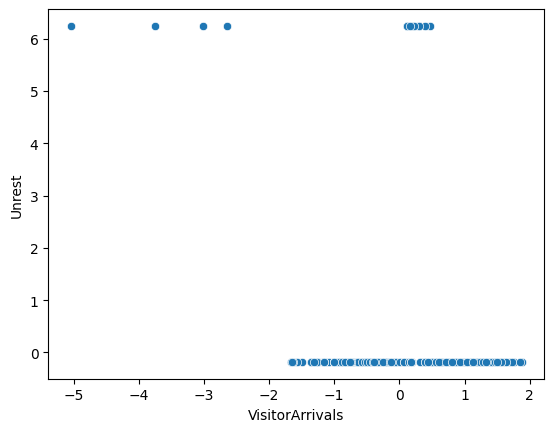

Pearson: -0.027121071130689314
Kendall: 0.011667005828742603
Spearman: 0.0181526851628306


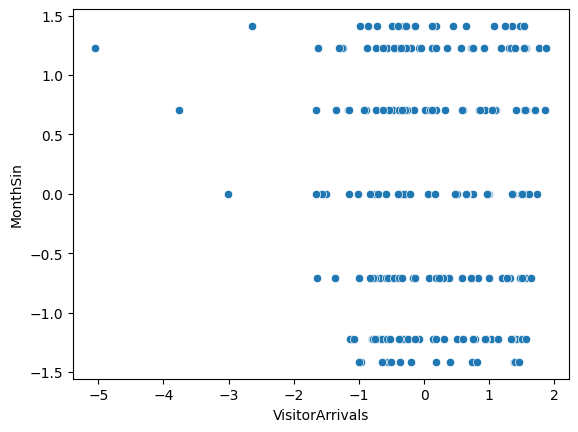

Pearson: -0.013873602451566975
Kendall: -0.03419632144286702
Spearman: -0.04873828967092543


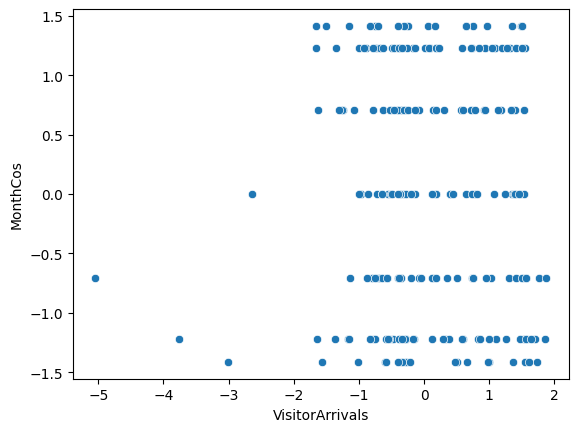

Pearson: 0.8837197173698108
Kendall: 0.7877726256985058
Spearman: 0.933307241384511


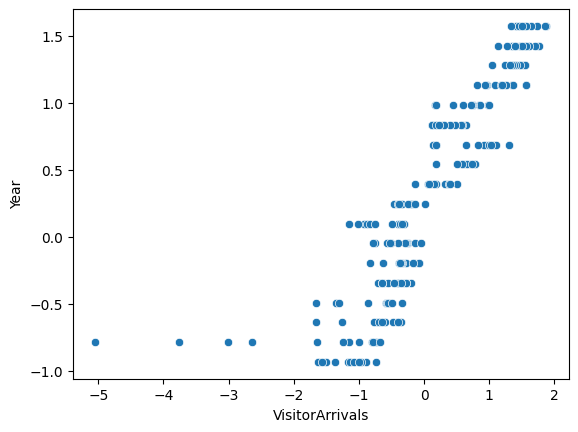

Pearson: -0.8397406847430228
Kendall: -0.7675279931093884
Spearman: -0.9310279950940115


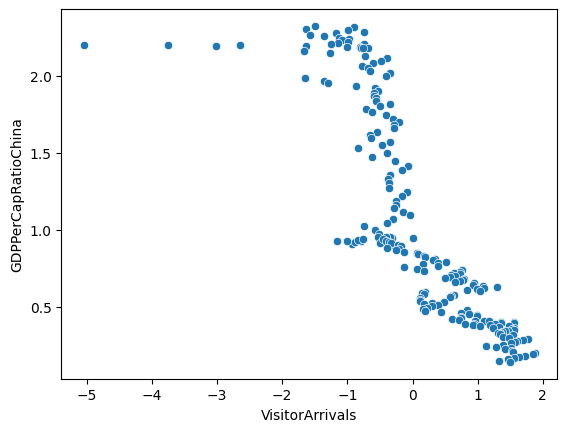

Pearson: -0.016179252434819304
Kendall: 0.04453057708871662
Spearman: 0.04770716488645971


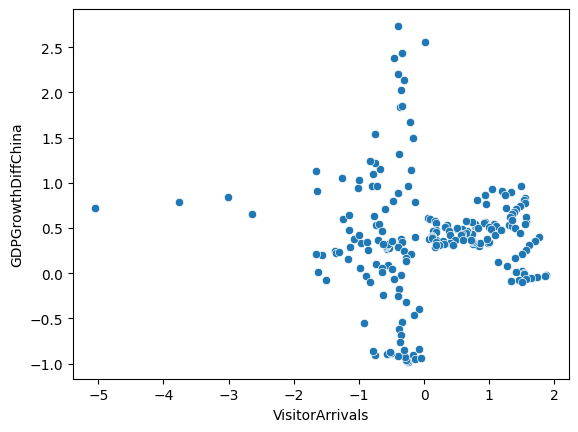

Pearson: 0.1104403635658284
Kendall: 0.10387596899224805
Spearman: 0.12904416580335556


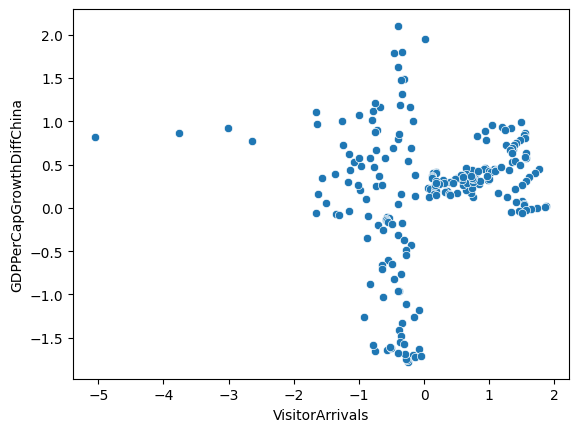

Pearson: nan
Kendall: nan
Spearman: nan


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


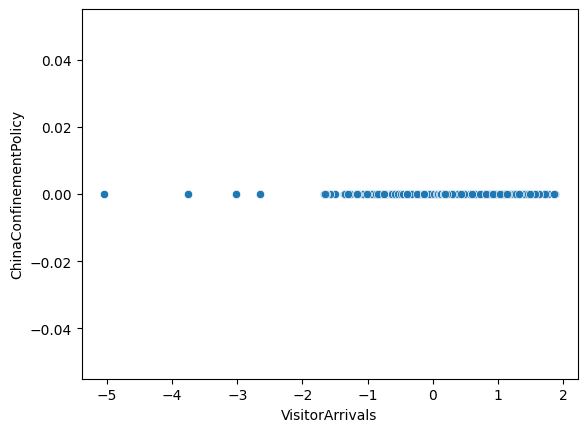

Pearson: nan
Kendall: nan
Spearman: nan


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


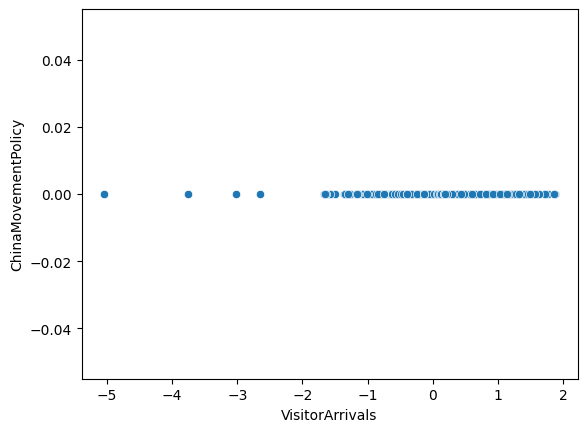

Pearson: 0.8835006063228442
Kendall: 0.7708871662360033
Spearman: 0.9334154967313255


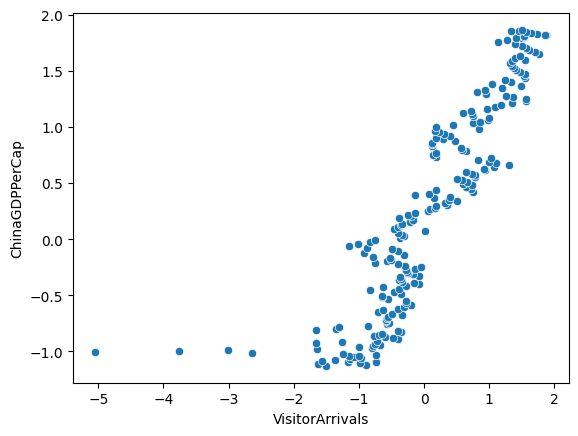

Pearson: 0.8829387153358654
Kendall: 0.7708871662360033
Spearman: 0.9334154967313255


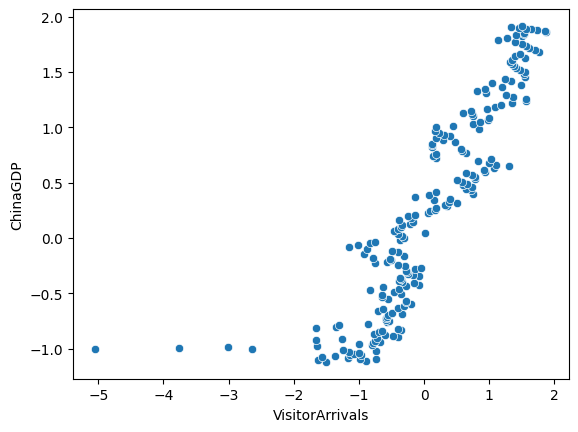

Pearson: nan
Kendall: nan
Spearman: nan


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


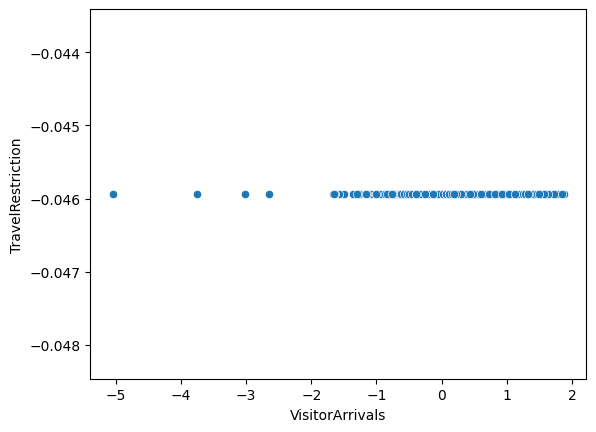

In [364]:
country_feat = [#'GDPPerCap', 'GDP', 'Population', 
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
target = 'VisitorArrivals'
all_data[country][country_feat + universal_feat + [target]].plot()
plt.show()
for candidate in country_feat + universal_feat:
    print('Pearson:', all_data[country][target].corr(all_data[country][candidate]))
    print('Kendall:', all_data[country][target].corr(all_data[country][candidate], method='kendall'))
    print('Spearman:', all_data[country][target].corr(all_data[country][candidate], method='spearman'))
    sns.scatterplot(all_data[country], x=target, y=candidate)
    plt.show()

In [365]:
# repeat for all countries
reg_pred, all_y = [], []
for country, df in all_data.items():
    print('processing', country)
    df = df.copy().dropna()
    train_x, train_y = df[country_feat + universal_feat], df[target]
    train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    best_param, best_mae = grid_search_ml(train_x, train_y, score_function=mean_absolute_error, preprocess=['nopreprocess'],#sample_weight=sample_weight,
                                           additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                              'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                              'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
    print(best_param, best_mae)
    model = get_model(best_param[0])
    model = model.set_params(**best_param[2])
    scaler = get_scaler(best_param[1])
    train_x_ = scaler.fit_transform(train_x)
    test_x_ = scaler.transform(test_x)
    model.fit(train_x_, train_y,)# sample_weight=sample_weight)
    pred = model.predict(test_x_)
    
    reg_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0., 
                                   y_scaler if single_y_scaler else y_scaler[country]))
    all_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0., 
                                y_scaler if single_y_scaler else y_scaler[country]))
    
reg_pred, all_y = np.concatenate(reg_pred), np.concatenate(all_y)

processing Canada
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 0.2544208511252828
processing Chile
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 0.24845239053683948
processing Mexico
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None,

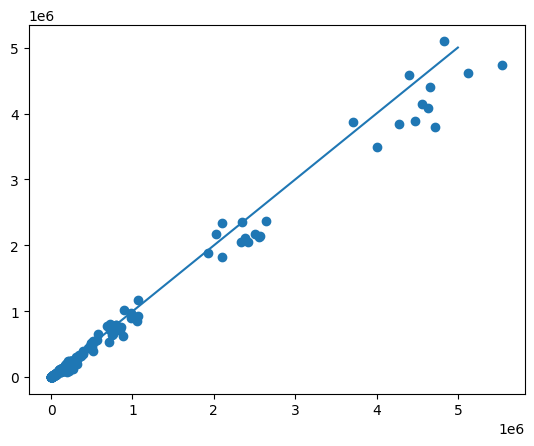

In [366]:
plt.scatter(all_y, reg_pred)
plt.plot((0, 5000000), (0, 5000000))

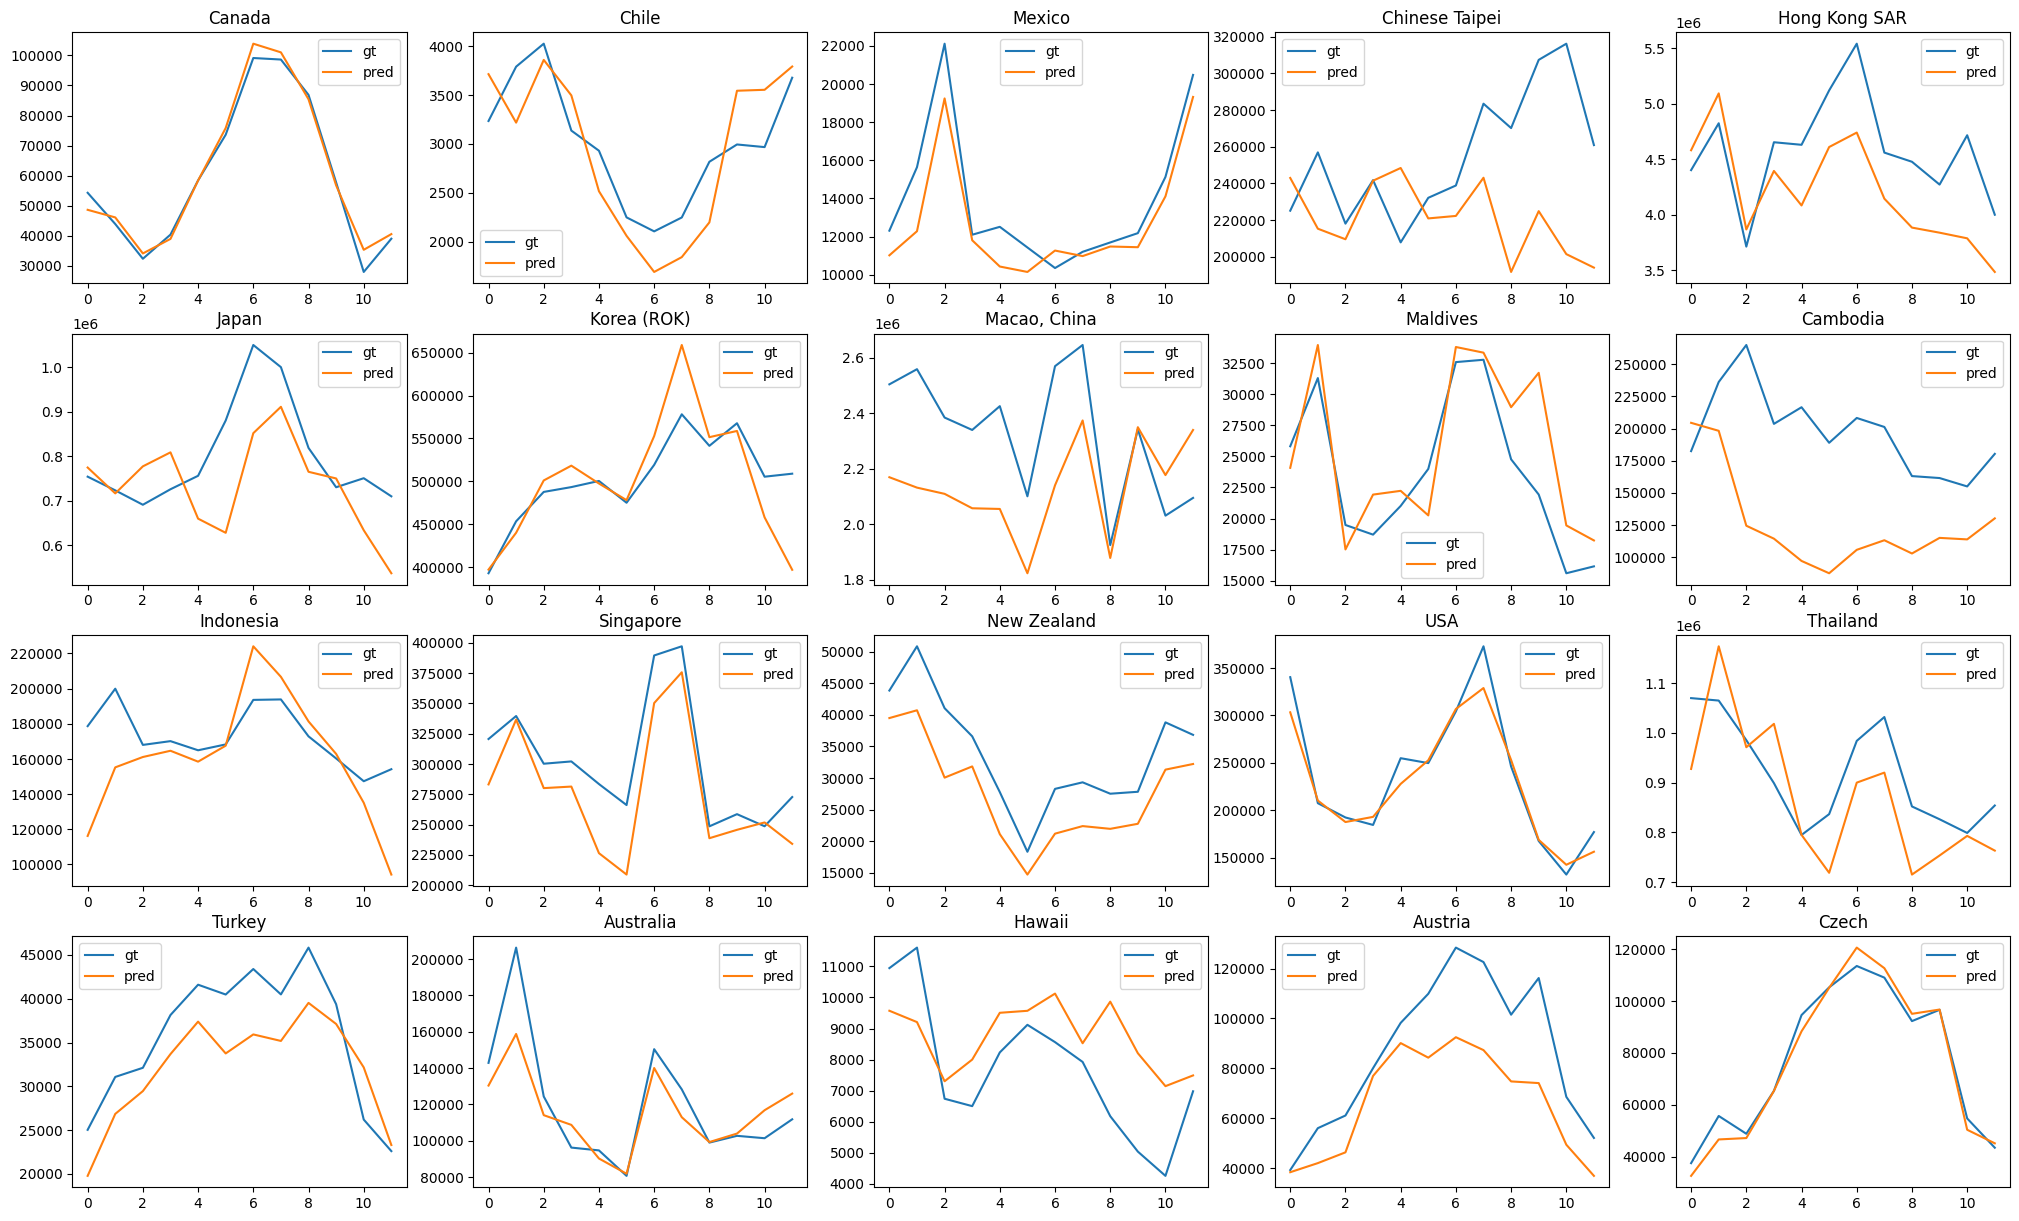

In [367]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [368]:
reg_rmse = sqrt(mean_squared_error(all_y, reg_pred))
reg_r2 = r2_score(all_y, reg_pred)
reg_mae = mean_absolute_error(all_y, reg_pred)
reg_mape = mean_absolute_percentage_error(all_y, reg_pred)
print(f'Baseline Model RMSE: {reg_rmse:.5f}\nBaseline Model R2: {reg_r2:.5f}\nBaseline Model MAE: {reg_mae:.5f}\nBaseline Model MAPE: {reg_mape:.5f}')

Baseline Model RMSE: 140284.71101
Baseline Model R2: 0.98284
Baseline Model MAE: 58781.90874
Baseline Model MAPE: 0.13232


## Combination Regression Model

In [745]:
country_feat = [#'GDPPerCap', 'GDP', 'Population', 
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI',
                   'DistFromChina', 'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']

In [746]:
# repeat for all countries
all_train_x, all_train_y, all_test_x, all_test_y = [], [], [], []
for country, df in all_data.items():
    df = df.copy().dropna()
    train_x, train_y = df[country_feat + universal_feat], df[target]
    train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    
    all_train_x.append(train_x)
    all_train_y.append(train_y)
    all_test_x.append(test_x)
    all_test_y.append(test_y)

all_train_x = pd.concat(all_train_x, ignore_index=True)
all_train_y = pd.concat(all_train_y, ignore_index=True)
# best_param, best_mae = grid_search_ml(all_train_x, all_train_y, score_function=mean_absolute_error, preprocess=['nopreprocess'],#sample_weight=sample_weight,
#                                        additional_params={'rf': [{'n_estimators': n} for n in (10, 25, 50, 100)],
#                                                           'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
#                                                           'xgb': [{'n_estimators': n} for n in (10, 25, 50, 100)]})

In [371]:
best_param, best_mae = ('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'n_estimators': 200}), 0.14475667605963807
print(best_param, best_mae)
model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
all_train_x_ = scaler.fit_transform(all_train_x)
model.fit(all_train_x_, all_train_y,)# sample_weight=sample_weight)

reg_comb_pred, all_comb_y = [], []
for country, test_x, test_y in zip(all_data.keys(), all_test_x, all_test_y):
    test_x_ = scaler.transform(test_x)
    pred = model.predict(test_x_)
    
    reg_comb_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                        y_scaler if single_y_scaler else y_scaler[country]))
    all_comb_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                     y_scaler if single_y_scaler else y_scaler[country]))

reg_comb_pred, all_comb_y = np.concatenate(reg_comb_pred), np.concatenate(all_comb_y)

('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'n_estimators': 200}) 0.14475667605963807


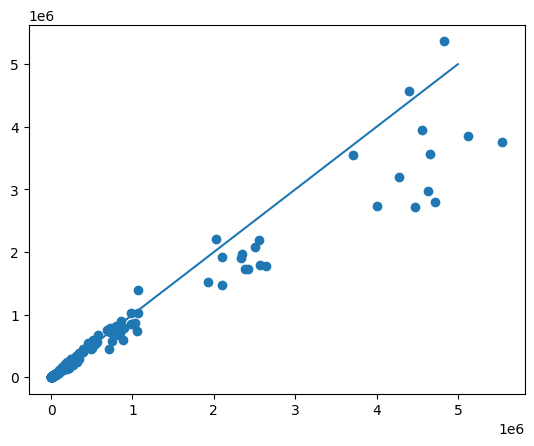

In [372]:
plt.scatter(all_y, reg_comb_pred)
plt.plot((0, 5000000), (0, 5000000))

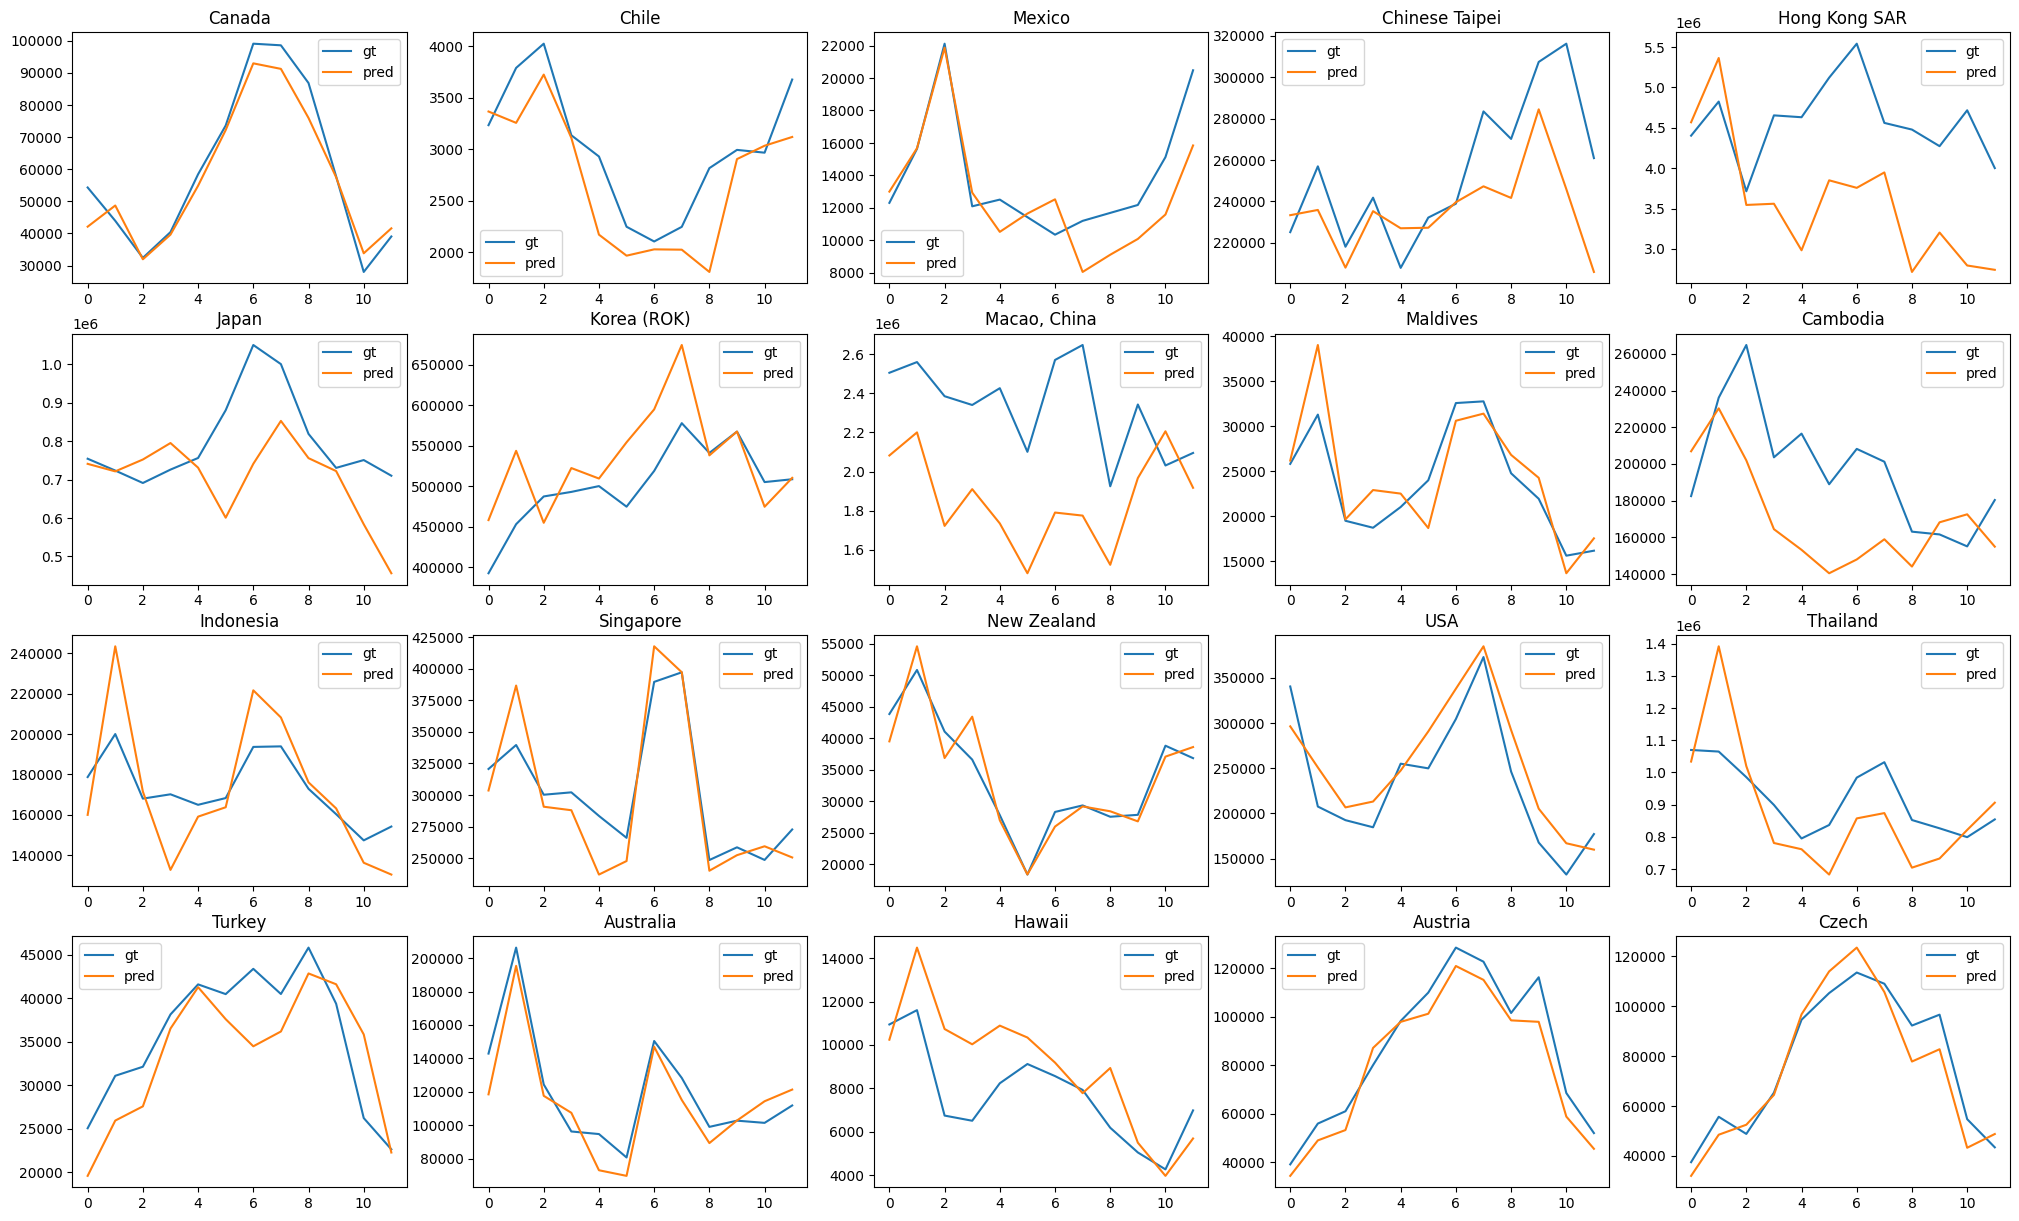

In [373]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_comb_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [374]:
(all_y == all_comb_y).all()

True

In [375]:
comb_rmse = sqrt(mean_squared_error(all_y, reg_comb_pred))
comb_r2 = r2_score(all_y, reg_comb_pred)
comb_mae = mean_absolute_error(all_y, reg_comb_pred)
comb_mape = mean_absolute_percentage_error(all_y, reg_comb_pred)
print(f'Combination Model RMSE: {comb_rmse:.5f}\nCombination Model R2: {comb_r2:.5f}\nCombination Model MAE: {comb_mae:.5f}\nCombination Model MAPE: {comb_mape:.5f}')

Combination Model RMSE: 310589.94183
Combination Model R2: 0.91589
Combination Model MAE: 102075.73744
Combination Model MAPE: 0.12477


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

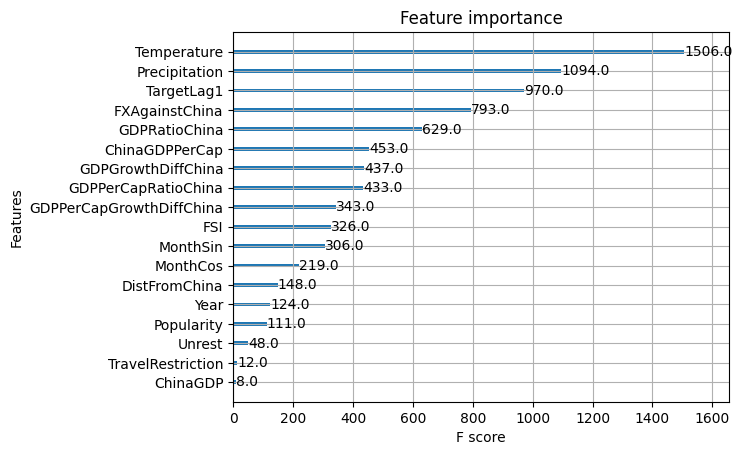

In [376]:
from xgboost import plot_importance
plot_importance(model)

In [377]:
# auto regressive predictions
reg_comb_pred, all_comb_y = [], []
for country, test_x, test_y in zip(all_data.keys(), all_test_x, all_test_y):
    test_x_ = scaler.transform(test_x)
    pred = []
    for i in range(len(test_x_)):
        if i > 0:
            test_x_.iloc[i:i+1, test_x_.columns.get_loc('TargetLag1')] = last_pred
        last_pred = model.predict(test_x_.iloc[i:i+1])
        pred.append(last_pred[0])
        
    pred = np.asarray(pred)
    
    reg_comb_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                        y_scaler if single_y_scaler else y_scaler[country]))
    all_comb_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                     y_scaler if single_y_scaler else y_scaler[country]))

reg_comb_pred, all_comb_y = np.concatenate(reg_comb_pred), np.concatenate(all_comb_y)

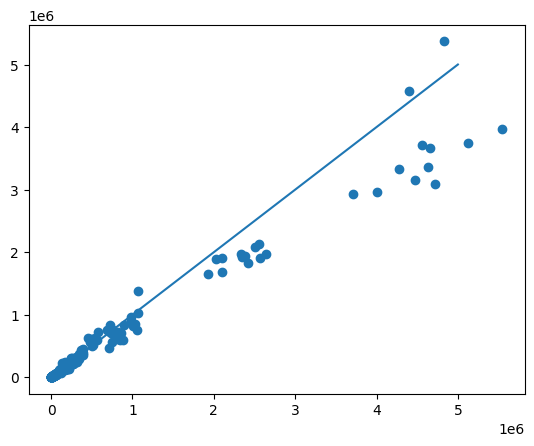

In [378]:
plt.scatter(all_y, reg_comb_pred)
plt.plot((0, 5000000), (0, 5000000))

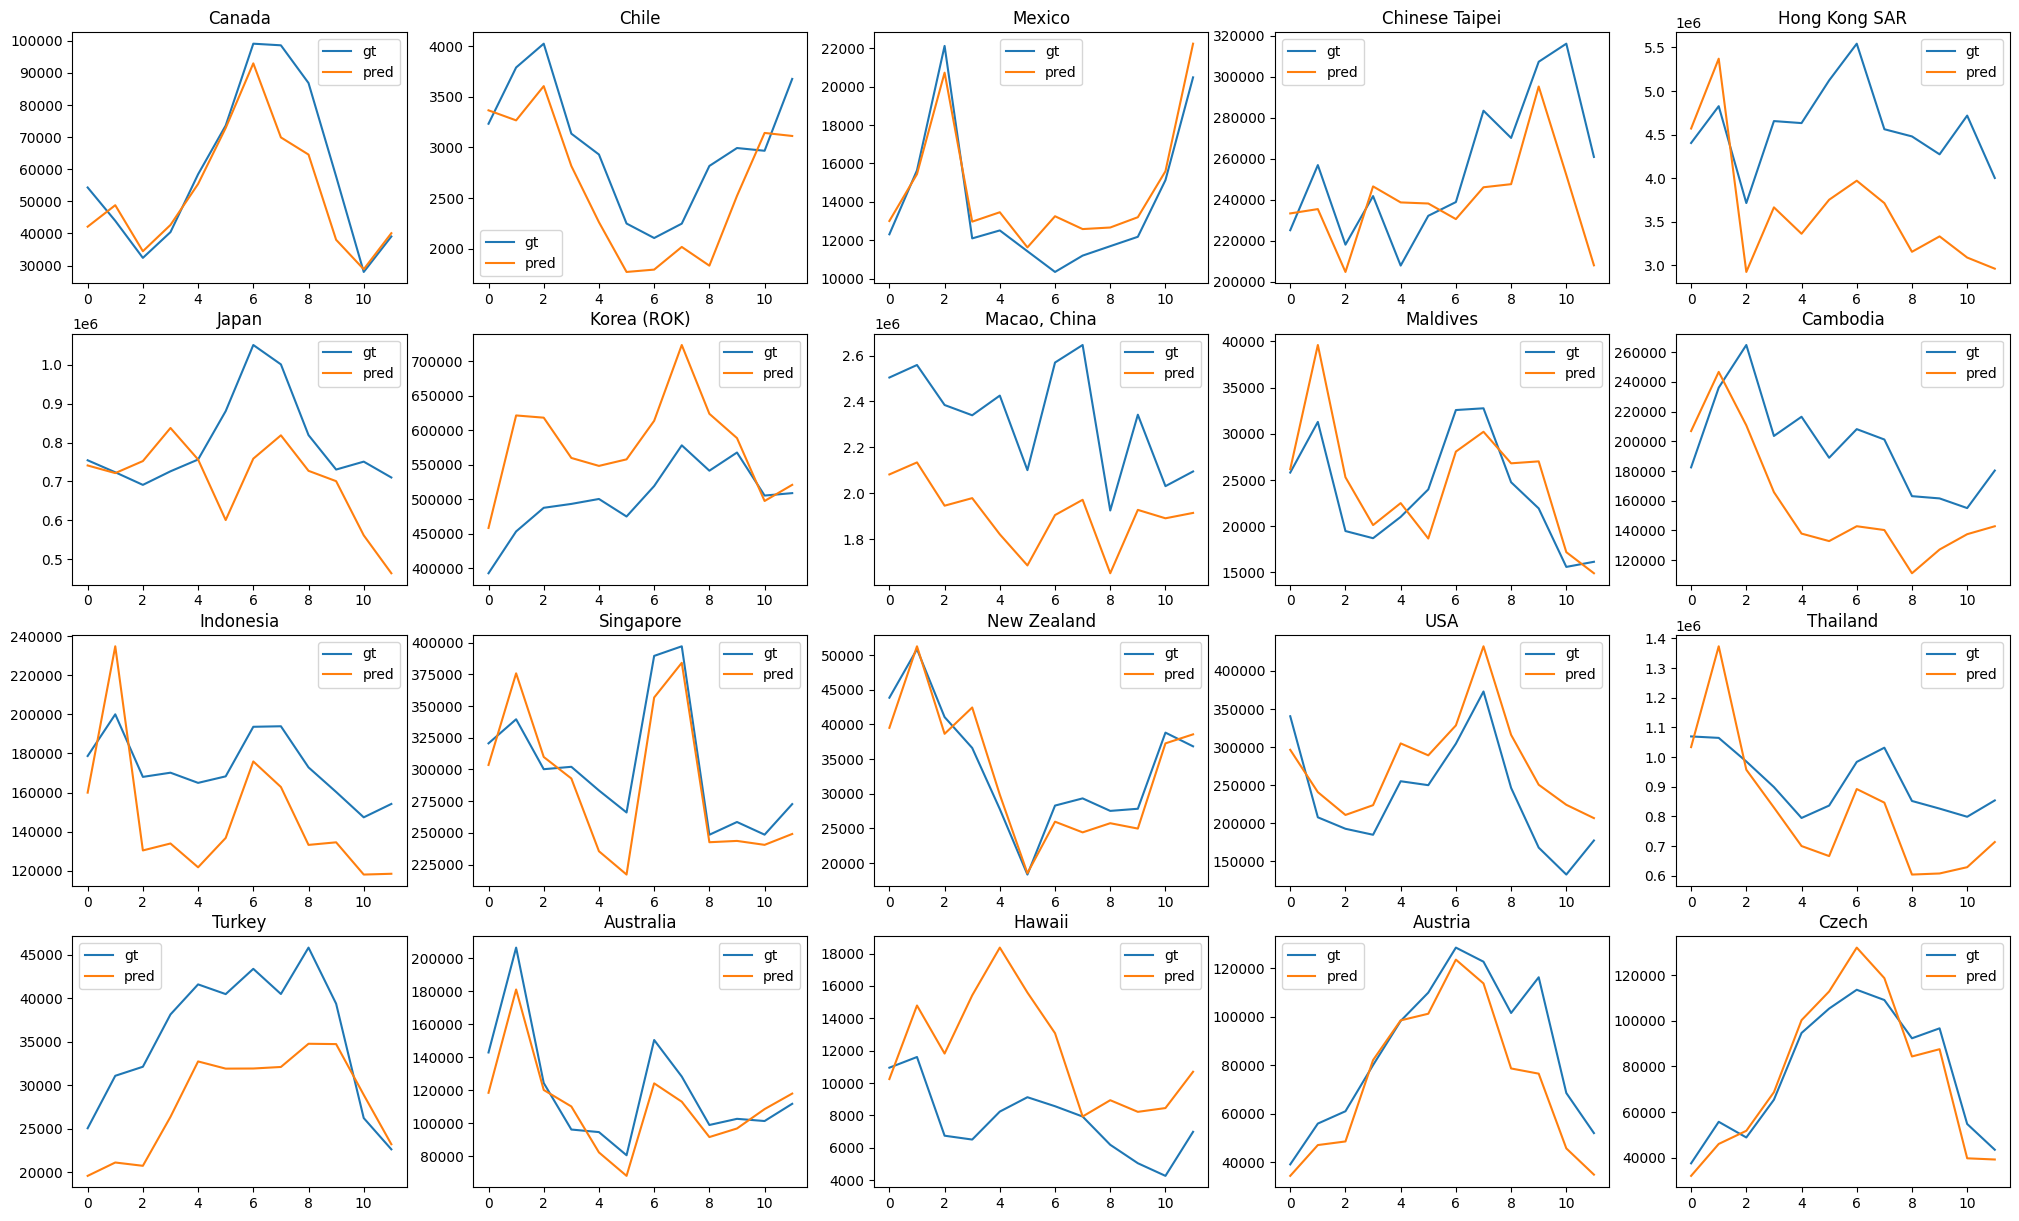

In [379]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_comb_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [380]:
comb_rmse = sqrt(mean_squared_error(all_y, reg_comb_pred))
comb_r2 = r2_score(all_y, reg_comb_pred)
comb_mae = mean_absolute_error(all_y, reg_comb_pred)
comb_mape = mean_absolute_percentage_error(all_y, reg_comb_pred)
print(f'Combination Model RMSE: {comb_rmse:.5f}\nCombination Model R2: {comb_r2:.5f}\nCombination Model MAE: {comb_mae:.5f}\nCombination Model MAPE: {comb_mape:.5f}')

Combination Model RMSE: 275995.97038
Combination Model R2: 0.93358
Combination Model MAE: 102020.28228
Combination Model MAPE: 0.17393


# RNN

In [762]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window(df, input_len=100, output_len=12, test_size=1,):
    df = df.copy().dropna()
    x, y = [], []
    if input_len <= 0:  # <=0 is full length
        input_len = len(df) - test_size * output_len * 2

    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
    y = np.asarray(y)
    return x[:-test_size*output_len], y[:-test_size*output_len], x[-test_size:], y[-test_size:]

In [763]:
seq_train_x, seq_train_y, seq_test_x, seq_test_y = sliding_window(all_data['Australia'], input_len=24, output_len=1, test_size=18)

In [764]:
len(country_feat + universal_feat)

19

In [765]:
seq_test_x[-1]

Temperature  Precipitation  FXAgainstChina       FSI    Country  \
Date                                                                          
2017-12-01     1.239293       0.300650       -0.259371 -1.243524  Australia   
2018-01-01     1.452494       1.700130       -0.259381 -1.308189  Australia   
2018-02-01     1.239293       1.503429       -0.259362 -1.308189  Australia   
2018-03-01     0.898171       0.855283       -0.259352 -1.308189  Australia   
2018-04-01     0.407807      -0.650609       -0.259342 -1.308189  Australia   
2018-05-01    -0.764801      -0.798941       -0.259335 -1.308189  Australia   
2018-06-01    -1.404406      -0.618363       -0.259343 -1.308189  Australia   
2018-07-01    -1.383086      -0.856984       -0.259361 -1.308189  Australia   
2018-08-01    -1.276485      -0.795717       -0.259368 -1.308189  Australia   
2018-09-01    -0.508959      -1.018215       -0.259356 -1.308189  Australia   
2018-10-01     0.450447      -0.608690       -0.259354 -1.308189  Australia   
2018-11-01     0.791570      -0.234635       -0.259370 -1.308189  Australia   
2018-12-01     1.388534       0.432859       -0.259358 -1.308189  Australia   
2019-01-01     1.623056       1.071331       -0.259344 -1.353467  Australia   
2019-02-01     1.281933       0.945572       -0.259337 -1.353467  Australia   
2019-03-01     1.047412       0.597314       -0.259328 -1.353467  Australia   
2019-04-01     0.215926      -0.476481       -0.259332 -1.353467  Australia   
2019-05-01    -0.700841      -0.640936       -0.259330 -1.353467  Australia   
2019-06-01    -1.404406      -0.608690       -0.259334 -1.353467  Australia   
2019-07-01    -1.340445      -0.895680       -0.259336 -1.353467  Australia   
2019-08-01    -1.233845      -0.882781       -0.259333 -1.353467  Australia   
2019-09-01    -0.423679      -1.063359       -0.259343 -1.353467  Australia   
2019-10-01     0.493088      -0.850535       -0.259339 -1.353467  Australia   
2019-11-01     0.855530      -0.679631       -0.259335 -1.353467  Australia   

            GDPRatioChina   Unrest  MonthSin  MonthCos      Year  \
Date                                                               
2017-12-01      -0.324747 -0.18031 -0.707559  1.225197  1.278775   
2018-01-01      -0.325192 -0.18031 -0.000452  1.414666  1.426371   
2018-02-01      -0.325630 -0.18031  0.706655  1.225197  1.426371   
2018-03-01      -0.326067 -0.18031  1.224293  0.707559  1.426371   
2018-04-01      -0.326505 -0.18031  1.413762  0.000452  1.426371   
2018-05-01      -0.326943 -0.18031  1.224293 -0.706655  1.426371   
2018-06-01      -0.327381 -0.18031  0.706655 -1.224293  1.426371   
2018-07-01      -0.327819 -0.18031 -0.000452 -1.413762  1.426371   
2018-08-01      -0.328256 -0.18031 -0.707559 -1.224293  1.426371   
2018-09-01      -0.328694 -0.18031 -1.225197 -0.706655  1.426371   
2018-10-01      -0.329132 -0.18031 -1.414666  0.000452  1.426371   
2018-11-01      -0.329570 -0.18031 -1.225197  0.707559  1.426371   
2018-12-01      -0.330008 -0.18031 -0.707559  1.225197  1.426371   
2019-01-01      -0.330445 -0.18031 -0.000452  1.414666  1.573967   
2019-02-01      -0.330857 -0.18031  0.706655  1.225197  1.573967   
2019-03-01      -0.331269 -0.18031  1.224293  0.707559  1.573967   
2019-04-01      -0.331681 -0.18031  1.413762  0.000452  1.573967   
2019-05-01      -0.332093 -0.18031  1.224293 -0.706655  1.573967   
2019-06-01      -0.332505 -0.18031  0.706655 -1.224293  1.573967   
2019-07-01      -0.332917 -0.18031 -0.000452 -1.413762  1.573967   
2019-08-01      -0.333329 -0.18031 -0.707559 -1.224293  1.573967   
2019-09-01      -0.333741 -0.18031 -1.225197 -0.706655  1.573967   
2019-10-01      -0.334153 -0.18031 -1.414666  0.000452  1.573967   
2019-11-01      -0.334565 -0.18031 -1.225197  0.707559  1.573967   

            GDPPerCapRatioChina  GDPGrowthDiffChina  GDPPerCapGrowthDiffChina  \
Date                                                                            
2017-12-01            -0.5

In [766]:
seq_test_y

array([[1.64531124],
       [1.55975782],
       [1.51102728],
       [1.4737245 ],
       [1.35565403],
       [1.41128635],
       [1.51215094],
       [1.64119054],
       [1.55888731],
       [1.39886375],
       [1.50724588],
       [1.48500076],
       [1.63071181],
       [1.62504136],
       [1.52082142],
       [1.48344308],
       [1.34504053],
       [1.3890522 ]])

In [767]:
seq_train_x, seq_val_x, seq_train_y, seq_val_y = train_test_split(seq_train_x, seq_train_y, test_size=0.2, stratify=None)
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
# val_dataset.set_initial_states(train_dataset.get_initial_states())
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())

In [768]:
len(train_dataset) + len(val_dataset)

330

In [611]:
def grid_search_rnn_custom(country_list, test_size=1, criterion_type='mse', model_types=None, input_size=19,
                    param_grids=None, max_epochs=50, verbose=True, cuda=True, output_len=12):
    if param_grids is None:
        param_grids = {}
    if model_types is None:
        model_types = ['lstm', 'gru']
    criterion = get_torch_criterion(criterion_type)

    best_score = np.inf
    best_param = None
    for seq_len in param_grids.get('seq_len', [24]):
        seq_train_x_ori, seq_train_y_ori, train_country = [], [], []
        for country in country_list:
            seq_train_x, seq_train_y, _, _ = sliding_window(all_data[country], input_len=seq_len, output_len=output_len, test_size=test_size)
            temp_country = [country] * len(seq_train_x)
            seq_train_x_ori.extend(seq_train_x)
            seq_train_y_ori.append(seq_train_y)
            train_country.extend(temp_country)
        seq_train_y_ori = np.concatenate(seq_train_y_ori)
        for batch_size in param_grids.get('batch_size', [64, 128]):
            for model_type in model_types:
                for num_layers in param_grids.get('num_layers', range(1, 3)): # 2 layers result in worse performance
                    for hidden_size in param_grids.get('hidden_size', [20, 50, 75]):
                        for optim_type in param_grids.get('optim_type', ['nadam', 'rmsprop']):
                            for lr in [0.001, 0.0005]:
                                model = ForecastModel(model_type, input_size=input_size, output_size=output_len, num_layers=num_layers, hidden_size=hidden_size, conditional_labels=country_list,)
                                optimizer = get_torch_optimizer(optim_type, model.parameters(), lr=lr)
                                score_list = []
                                kf = StratifiedKFold()
                                for train_index, test_index in kf.split(seq_train_x_ori, train_country):
                                    seq_train_x, seq_val_x = [seq_train_x_ori[i] for i in train_index], [seq_train_x_ori[i] for i in test_index]
                                    seq_train_y, seq_val_y  = seq_train_y_ori[train_index], seq_train_y_ori[test_index]
                                    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
                                    # train_dataset.initialize_states()
                                    val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
                                    # val_dataset.set_initial_states(train_dataset.get_initial_states())
                                    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)
                                    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)
                                    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=max_epochs, verbose=False, cuda=cuda)

                                    score_list.append(sqrt(val_losses[-1]) if criterion_type == 'mse' else val_losses[-1])
                                score = np.mean(score_list)
                                if score < best_score:
                                    best_score = score
                                    best_param = ({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                                  {'optim_type': optim_type, 'lr': lr})
                                if verbose:
                                    print(({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                          {'optim_type': optim_type, 'lr': lr}), round(score, 5), round(np.std(score_list), 5))
    return best_param, best_score

In [612]:
best_param, best_rmse = grid_search_rnn_custom(country_list)
best_param, best_rmse

({'seq_len': 24, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20}, {'optim_type': 'nadam', 'lr': 0.001}) 0.31289 0.0872
({'seq_len': 24, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20}, {'optim_type': 'nadam', 'lr': 0.0005}) 0.31044 0.0847
({'seq_len': 24, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20}, {'optim_type': 'rmsprop', 'lr': 0.001}) 0.31518 0.07249
({'seq_len': 24, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20}, {'optim_type': 'rmsprop', 'lr': 0.0005}) 0.31866 0.07611
({'seq_len': 24, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 50}, {'optim_type': 'nadam', 'lr': 0.001}) 0.28695 0.05288
({'seq_len': 24, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 50}, {'optim_type': 'nadam', 'lr': 0.0005}) 0.28885 0.05802
({'seq_len': 24, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 50},

(({'seq_len': 24, 'batch_size': 128},
  {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 50},
  {'optim_type': 'nadam', 'lr': 0.001}),
 0.2735514617373008)

Epoch 0: train loss 0.4918, val loss 0.3603, time 1.4092
Epoch 1: train loss 0.2548, val loss 0.2560, time 1.2333
Epoch 2: train loss 0.2356, val loss 0.2381, time 1.2331
Epoch 3: train loss 0.2282, val loss 0.2232, time 1.2380
Epoch 4: train loss 0.2228, val loss 0.2245, time 1.2448
Epoch 5: train loss 0.2175, val loss 0.2215, time 1.2614
Epoch 6: train loss 0.2173, val loss 0.2154, time 1.2567
Epoch 7: train loss 0.2141, val loss 0.2140, time 1.2298
Epoch 8: train loss 0.2112, val loss 0.2059, time 1.2331
Epoch 9: train loss 0.2067, val loss 0.2425, time 1.2310
Epoch 10: train loss 0.2093, val loss 0.2060, time 1.2375
Epoch 11: train loss 0.2083, val loss 0.2140, time 1.2417
Epoch 12: train loss 0.2078, val loss 0.2396, time 1.2515
Epoch 13: train loss 0.2071, val loss 0.2047, time 1.2308
Epoch 14: train loss 0.2046, val loss 0.2080, time 1.2458
Epoch 15: train loss 0.2067, val loss 0.2177, time 1.2643
Epoch 16: train loss 0.2048, val loss 0.2167, time 1.1959
Early stopping as no imp

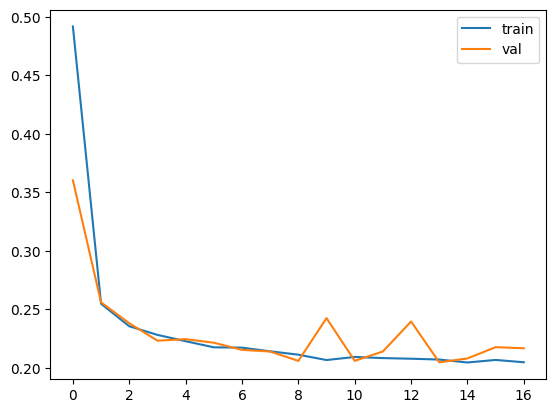

In [769]:
best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'nadam', 'lr': 0.001})
output_size=12
seq_train_x_ori, seq_train_y_ori, seq_test_x_ori, seq_test_y_ori = [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, seq_test_x, seq_test_y = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)

model = ForecastModel(**best_param[1], input_size=19, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = nn.L1Loss()

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [770]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
# rnn_preds, rnn_gts = [], []
# for country in all_data.keys():
#     test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
#     preds = []
#     for i in range(len(test_x_)):
#         if i > 0:
#             last_pred = np.concatenate(preds)[-len(test_x_[i]):]
#             test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
#         init_state = model.get_embeddings([country])
#         x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
#         init_state, x_input = init_state.cuda(), x_input.cuda()
#         pred = model(x_input, init_state).detach().cpu().numpy()[0]
#         preds.append(pred)
        
#     preds = np.concatenate(preds)
#     gts = np.concatenate(test_y_)
#     rnn_preds.append(preds)
#     rnn_gts.append(gts)

# rnn_preds = np.asarray(rnn_preds)
# rnn_gts = np.asarray(rnn_gts)

In [771]:
rnn_pred, rnn_gt = [], []

for i in range(len(test_dataset)):
    country, ds_x, ds_y = test_dataset.__getitem__(i)
# for i, country in enumerate(all_data.keys()):
#     ds_y = rnn_gts[i]
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

In [772]:
(rnn_gt == all_y).all()

True

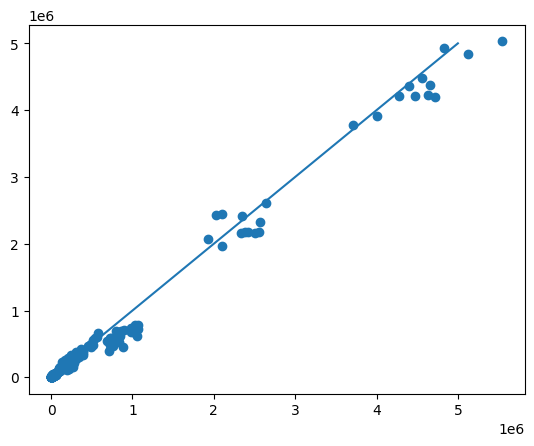

In [773]:
plt.scatter(all_y, rnn_pred)
plt.plot((0, 5000000), (0, 5000000))

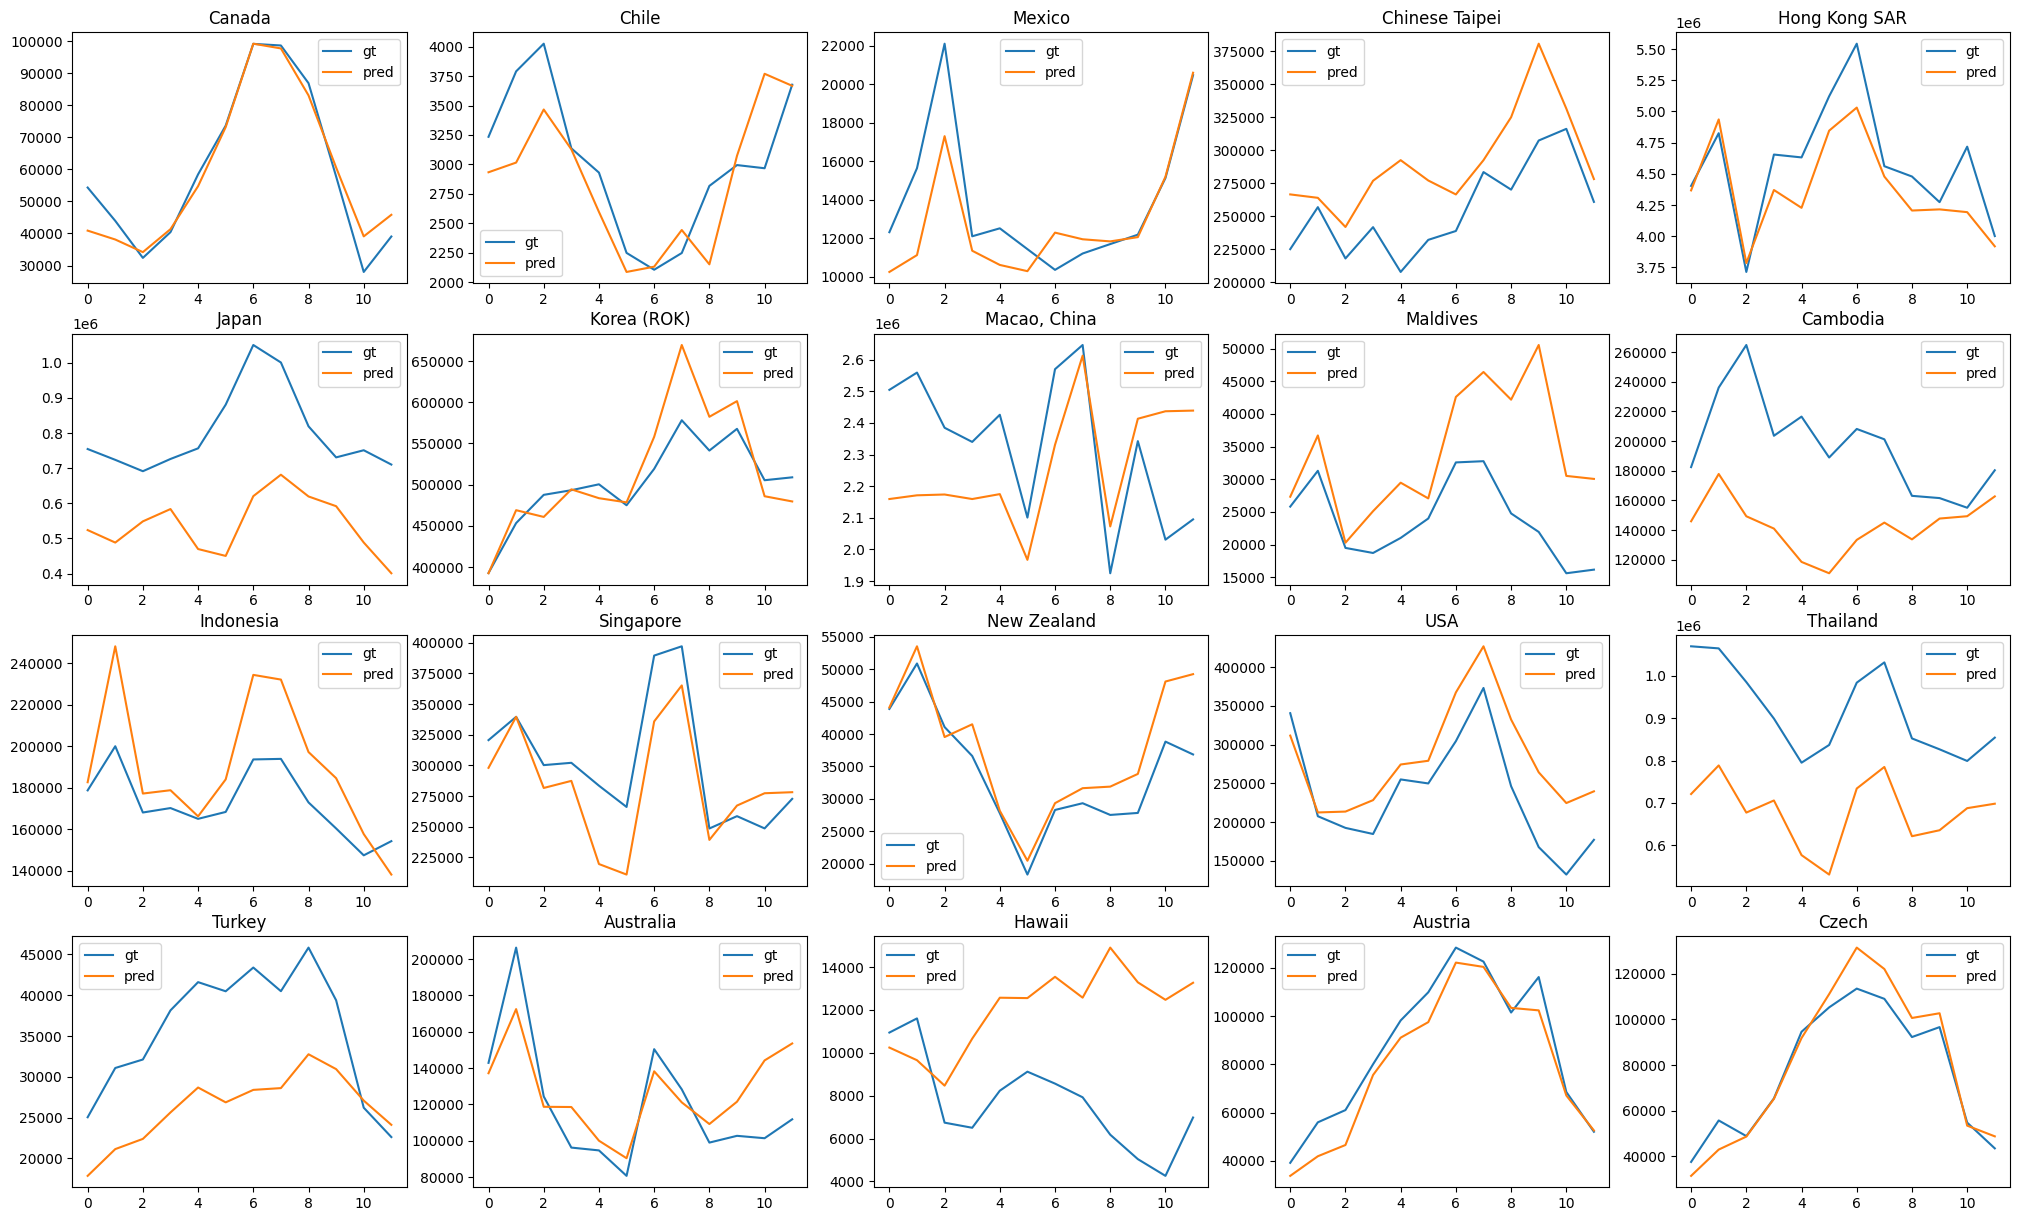

In [774]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [775]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}\nRNN MAPE: {rnn_mape:.5f}')

RNN RMSE: 121990.61351
RNN R2: 0.98702
RNN MAE: 61590.19784
RNN MAPE: 0.19417


# One Step RNN

In [776]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'

In [777]:
len(country_feat + universal_feat)

19

In [847]:
def grid_search_rnn_custom(country_list, test_size=1, criterion_type='mae', model_types=None, input_size=19,
                    param_grids=None, max_epochs=50, verbose=True, cuda=True, output_len=12):
    if param_grids is None:
        param_grids = {}
    if model_types is None:
        model_types = ['lstm', 'gru']
    criterion = get_torch_criterion(criterion_type)

    best_score = np.inf
    best_param = None
    for seq_len in param_grids.get('seq_len', [36]):
        seq_train_x_ori, seq_train_y_ori, train_country = [], [], []
        for country in country_list:
            seq_train_x, seq_train_y, _, _ = sliding_window(all_data[country], input_len=seq_len, output_len=output_len, test_size=test_size)
            temp_country = [country] * len(seq_train_x)
            seq_train_x_ori.extend(seq_train_x)
            seq_train_y_ori.append(seq_train_y)
            train_country.extend(temp_country)
        seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
        for batch_size in param_grids.get('batch_size', [64, 128, 256]):
            for model_type in model_types:
                for num_layers in param_grids.get('num_layers', range(1, 4)): # 4 layers result in worse performance
                    for hidden_size in param_grids.get('hidden_size', [50, 75, 100]):
                        for optim_type in param_grids.get('optim_type', ['nadam', 'rmsprop']):
                            for lr in [0.001, 0.0005]:
                                model = ForecastModel(model_type, input_size=input_size, output_size=output_len, num_layers=num_layers, hidden_size=hidden_size, conditional_labels=country_list,)
                                optimizer = get_torch_optimizer(optim_type, model.parameters(), lr=lr)
                                score_list = []
                                kf = StratifiedKFold()
                                for train_index, test_index in kf.split(seq_train_x_ori, train_country):
                                    seq_train_x, seq_val_x = [seq_train_x_ori[i] for i in train_index], [seq_train_x_ori[i] for i in test_index]
                                    seq_train_y, seq_val_y  = seq_train_y_ori[train_index], seq_train_y_ori[test_index]
                                    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
                                    # train_dataset.initialize_states()
                                    val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
                                    # val_dataset.set_initial_states(train_dataset.get_initial_states())
                                    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)
                                    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)
                                    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=max_epochs, verbose=False, cuda=cuda)

                                    score_list.append(sqrt(val_losses[-1]) if criterion_type == 'mse' else val_losses[-1])
                                score = np.mean(score_list)
                                if score < best_score:
                                    best_score = score
                                    best_param = ({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                                  {'optim_type': optim_type, 'lr': lr})
                                if verbose:
                                    print(({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                          {'optim_type': optim_type, 'lr': lr}), round(score, 5), round(np.std(score_list), 5))
    return best_param, best_score

In [848]:
best_param, best_rmse = grid_search_rnn_custom(country_list, test_size=12, output_len=1)
best_param, best_rmse

({'seq_len': 36, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 50}, {'optim_type': 'nadam', 'lr': 0.001}) 0.14638 0.03462
({'seq_len': 36, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 50}, {'optim_type': 'nadam', 'lr': 0.0005}) 0.15131 0.03922
({'seq_len': 36, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 50}, {'optim_type': 'rmsprop', 'lr': 0.001}) 0.16923 0.03539
({'seq_len': 36, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 50}, {'optim_type': 'rmsprop', 'lr': 0.0005}) 0.14831 0.02926
({'seq_len': 36, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 75}, {'optim_type': 'nadam', 'lr': 0.001}) 0.14072 0.02573
({'seq_len': 36, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 75}, {'optim_type': 'nadam', 'lr': 0.0005}) 0.14752 0.03264
({'seq_len': 36, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 75

(({'seq_len': 36, 'batch_size': 256},
  {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
  {'optim_type': 'rmsprop', 'lr': 0.0005}),
 0.13565041363778116)

Epoch 0: train loss 0.4175, val loss 0.2922, time 1.5690
Epoch 1: train loss 0.2441, val loss 0.2039, time 1.3836
Epoch 2: train loss 0.1844, val loss 0.1463, time 1.4005
Epoch 3: train loss 0.1690, val loss 0.1413, time 1.3904
Epoch 4: train loss 0.1652, val loss 0.1283, time 1.3929
Epoch 5: train loss 0.1545, val loss 0.1538, time 1.3835
Epoch 6: train loss 0.1535, val loss 0.1515, time 1.3845
Epoch 7: train loss 0.1560, val loss 0.1467, time 1.3802
Epoch 8: train loss 0.1506, val loss 0.1301, time 1.3785
Epoch 9: train loss 0.1500, val loss 0.1380, time 1.4042
Epoch 10: train loss 0.1521, val loss 0.1328, time 1.3994
Epoch 11: train loss 0.1497, val loss 0.1331, time 1.3823
Epoch 12: train loss 0.1484, val loss 0.1351, time 1.3924
Epoch 13: train loss 0.1502, val loss 0.1306, time 1.3813
Early stopping as no improvement in val loss


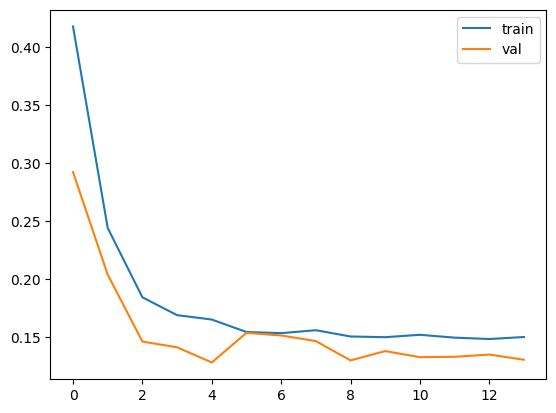

In [849]:
best_param = ({'seq_len': 36, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.0005})
output_size=1
seq_train_x_ori, seq_train_y_ori, seq_test_x_ori, seq_test_y_ori = [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, seq_test_x, seq_test_y = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size, test_size=12)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
seq_test_y_ori = np.concatenate(seq_test_y_ori).squeeze()

model = ForecastModel(**best_param[1], input_size=19, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = nn.L1Loss()

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [850]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, rnn_gts = [], []
for country in all_data.keys():
    test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
    preds = []
    for i in range(len(test_x_)):
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x_[i]):]
            test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
        
    preds = np.concatenate(preds)
    gts = np.asarray(test_y_)
    rnn_preds.append(preds)
    rnn_gts.append(gts)

rnn_preds = np.asarray(rnn_preds)
rnn_gts = np.asarray(rnn_gts)

In [851]:
rnn_pred, rnn_gt = [], []

# for i in range(len(test_dataset)):
#     country, ds_x, ds_y = test_dataset.__getitem__(i)
for i, country in enumerate(all_data.keys()):
    ds_y = rnn_gts[i]
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

In [852]:
(rnn_gt == all_y).all()

True

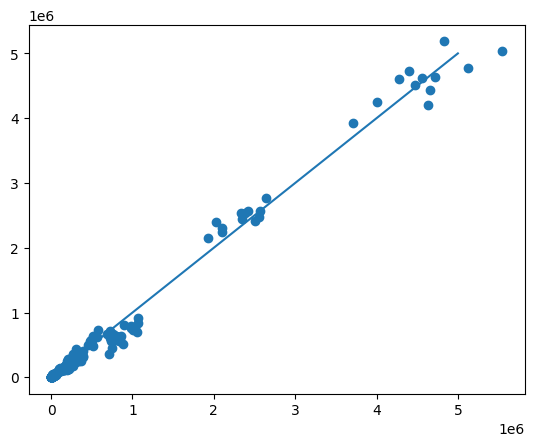

In [853]:
plt.scatter(all_y, rnn_pred)
plt.plot((0, 5000000), (0, 5000000))

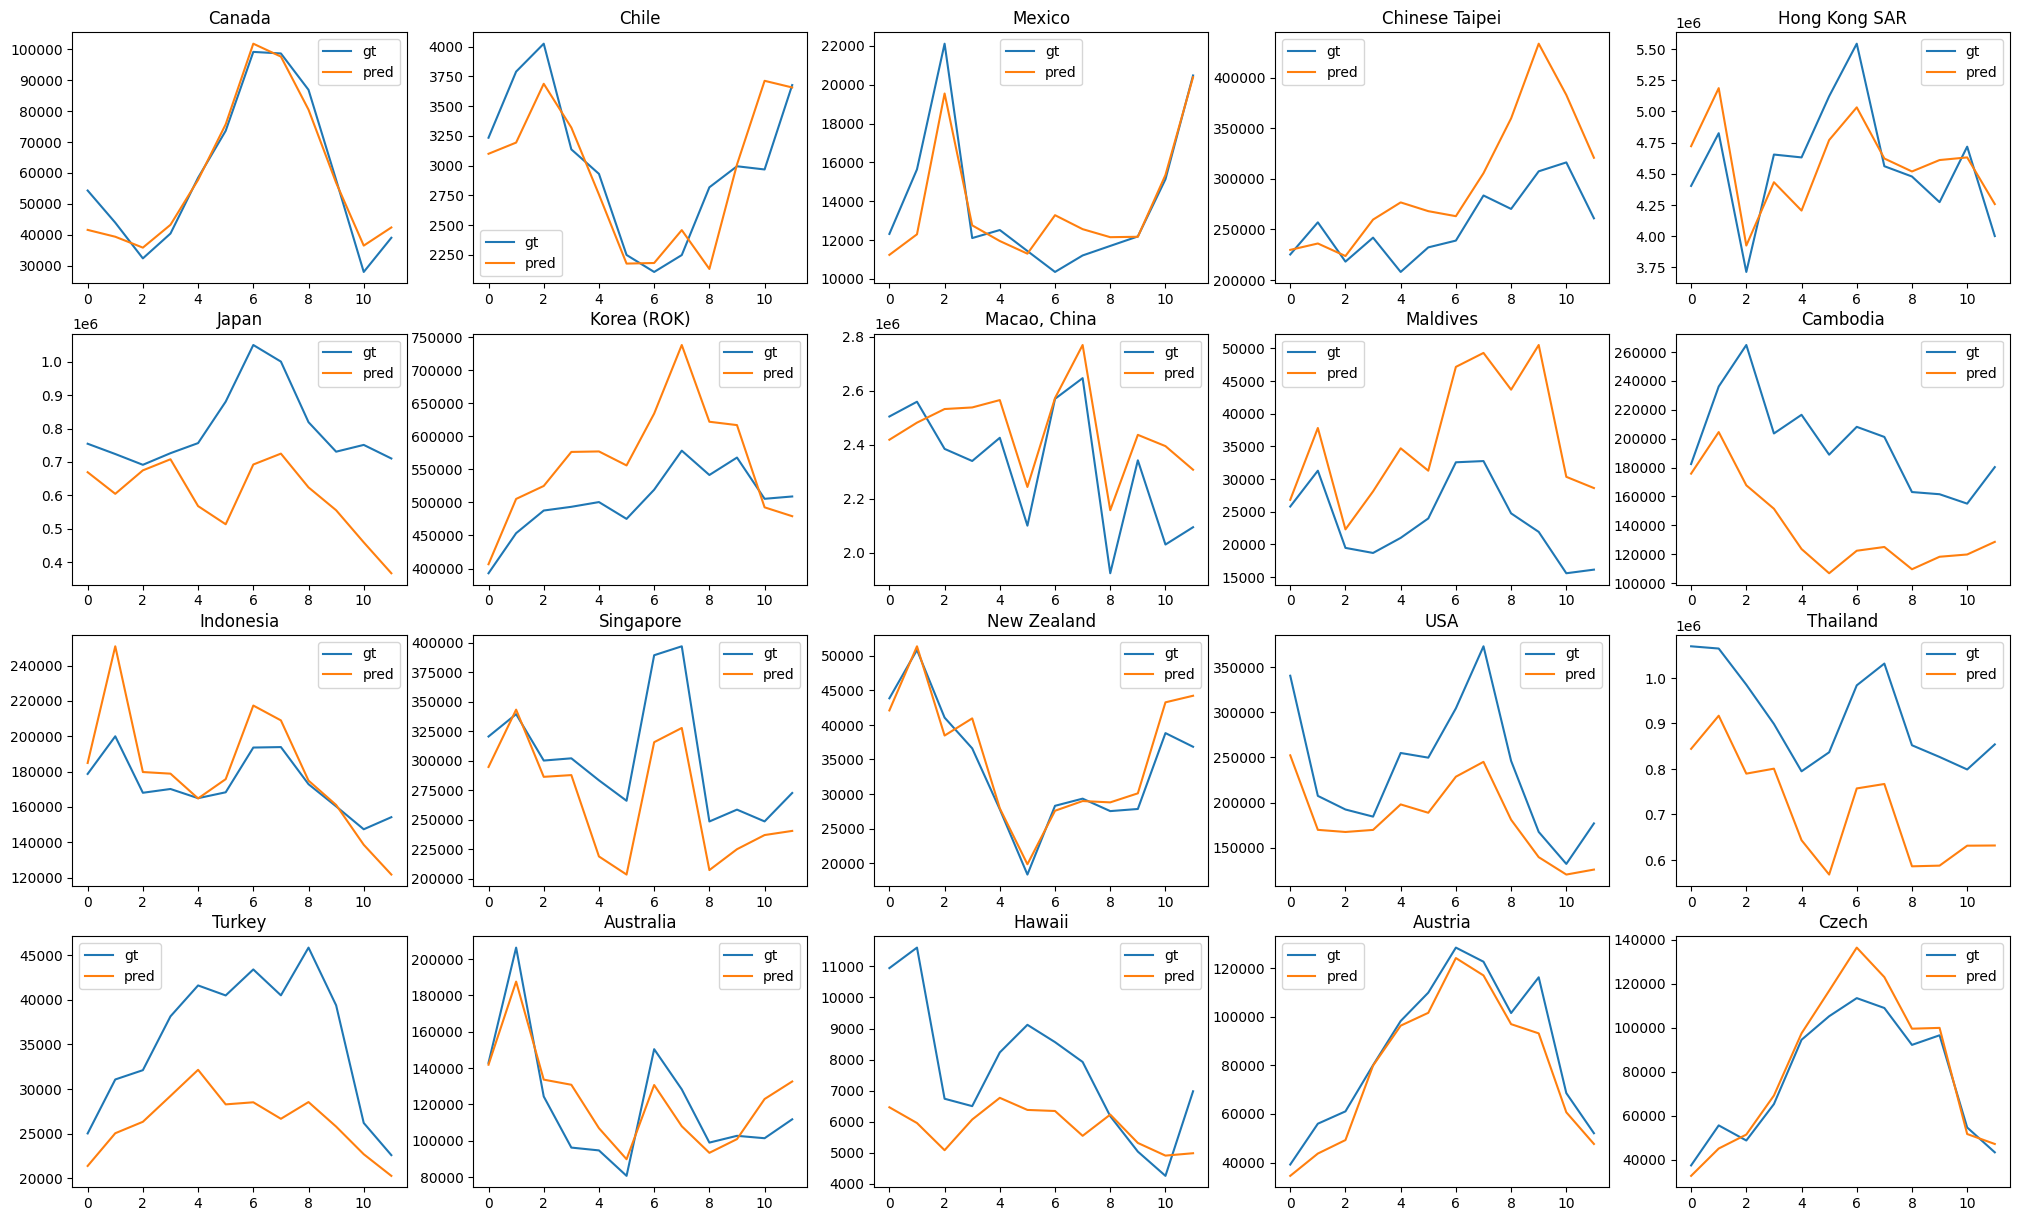

In [854]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [855]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}\nRNN MAPE: {rnn_mape:.5f}')

RNN RMSE: 110190.00389
RNN R2: 0.98941
RNN MAE: 58085.11121
RNN MAPE: 0.16378


# Separate RNN models

In [592]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
# static_feat = ['DistFromChina', 'Popularity']

Canada
Epoch 0: train loss 0.7649, val loss 1.5471, time 0.0712
Epoch 1: train loss 0.7657, val loss 1.5343, time 0.0612
Epoch 2: train loss 0.7486, val loss 1.5188, time 0.0598
Epoch 3: train loss 0.7294, val loss 1.5023, time 0.0598
Epoch 4: train loss 0.7242, val loss 1.4833, time 0.0590
Epoch 5: train loss 0.7200, val loss 1.4607, time 0.0640
Epoch 6: train loss 0.7141, val loss 1.4337, time 0.0636
Epoch 7: train loss 0.6909, val loss 1.4025, time 0.0633
Epoch 8: train loss 0.6706, val loss 1.3667, time 0.0622
Epoch 9: train loss 0.6440, val loss 1.3260, time 0.0635
Epoch 10: train loss 0.6076, val loss 1.2805, time 0.0612
Epoch 11: train loss 0.5809, val loss 1.2267, time 0.0612
Epoch 12: train loss 0.5461, val loss 1.1648, time 0.0616
Epoch 13: train loss 0.5094, val loss 1.0968, time 0.0631
Epoch 14: train loss 0.4834, val loss 1.0353, time 0.0621
Epoch 15: train loss 0.4550, val loss 0.9781, time 0.0622
Epoch 16: train loss 0.4117, val loss 0.9185, time 0.0631
Epoch 17: train l

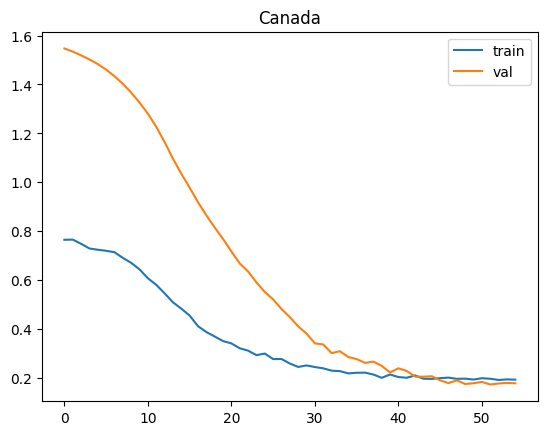

Chile
Epoch 0: train loss 0.8808, val loss 1.5780, time 0.0268
Epoch 1: train loss 0.8763, val loss 1.5721, time 0.0211
Epoch 2: train loss 0.8760, val loss 1.5672, time 0.0190
Epoch 3: train loss 0.8708, val loss 1.5616, time 0.0189
Epoch 4: train loss 0.8729, val loss 1.5556, time 0.0188
Epoch 5: train loss 0.8660, val loss 1.5499, time 0.0190
Epoch 6: train loss 0.8672, val loss 1.5441, time 0.0187
Epoch 7: train loss 0.8629, val loss 1.5374, time 0.0191
Epoch 8: train loss 0.8638, val loss 1.5314, time 0.0202
Epoch 9: train loss 0.8597, val loss 1.5249, time 0.0194
Epoch 10: train loss 0.8555, val loss 1.5177, time 0.0195
Epoch 11: train loss 0.8545, val loss 1.5103, time 0.0212
Epoch 12: train loss 0.8518, val loss 1.5027, time 0.0192
Epoch 13: train loss 0.8503, val loss 1.4950, time 0.0189
Epoch 14: train loss 0.8508, val loss 1.4867, time 0.0189
Epoch 15: train loss 0.8374, val loss 1.4771, time 0.0188
Epoch 16: train loss 0.8364, val loss 1.4673, time 0.0190
Epoch 17: train lo

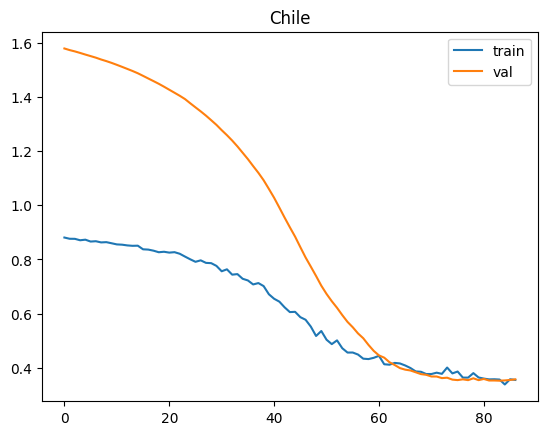

Mexico
Epoch 0: train loss 0.6995, val loss 1.4961, time 0.0606
Epoch 1: train loss 0.7425, val loss 1.4806, time 0.0512
Epoch 2: train loss 0.6477, val loss 1.4699, time 0.0519
Epoch 3: train loss 0.7598, val loss 1.4496, time 0.0504
Epoch 4: train loss 0.7510, val loss 1.4281, time 0.0514
Epoch 5: train loss 0.7523, val loss 1.3993, time 0.0509
Epoch 6: train loss 0.7201, val loss 1.3718, time 0.0512
Epoch 7: train loss 0.6822, val loss 1.3283, time 0.0503
Epoch 8: train loss 0.6366, val loss 1.2806, time 0.0511
Epoch 9: train loss 0.6430, val loss 1.2334, time 0.0519
Epoch 10: train loss 0.5610, val loss 1.1748, time 0.0522
Epoch 11: train loss 0.5728, val loss 1.1124, time 0.0514
Epoch 12: train loss 0.5514, val loss 1.0446, time 0.0508
Epoch 13: train loss 0.5128, val loss 0.9716, time 0.0511
Epoch 14: train loss 0.4706, val loss 0.9104, time 0.0513
Epoch 15: train loss 0.4396, val loss 0.8656, time 0.0517
Epoch 16: train loss 0.4289, val loss 0.7985, time 0.0514
Epoch 17: train l

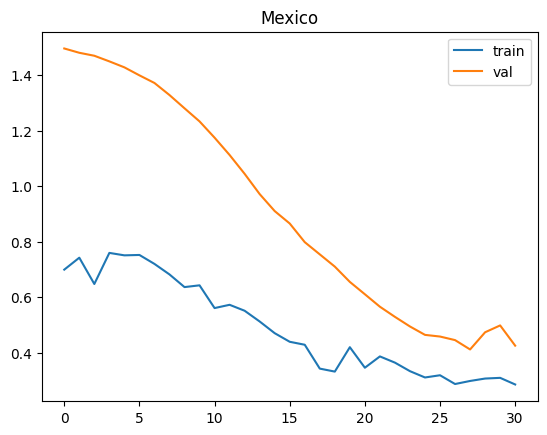

Chinese Taipei
Epoch 0: train loss 0.5715, val loss 0.4767, time 0.0381
Epoch 1: train loss 0.5948, val loss 0.4666, time 0.0354
Epoch 2: train loss 0.5658, val loss 0.4553, time 0.0337
Epoch 3: train loss 0.5347, val loss 0.4440, time 0.0332
Epoch 4: train loss 0.5786, val loss 0.4310, time 0.0332
Epoch 5: train loss 0.5691, val loss 0.4193, time 0.0328
Epoch 6: train loss 0.5635, val loss 0.4052, time 0.0334
Epoch 7: train loss 0.5115, val loss 0.3904, time 0.0344
Epoch 8: train loss 0.5351, val loss 0.3727, time 0.0329
Epoch 9: train loss 0.5076, val loss 0.3522, time 0.0331
Epoch 10: train loss 0.5013, val loss 0.3284, time 0.0332
Epoch 11: train loss 0.4884, val loss 0.3005, time 0.0333
Epoch 12: train loss 0.4635, val loss 0.2816, time 0.0328
Epoch 13: train loss 0.4839, val loss 0.2614, time 0.0335
Epoch 14: train loss 0.4655, val loss 0.2441, time 0.0335
Epoch 15: train loss 0.4349, val loss 0.2271, time 0.0332
Epoch 16: train loss 0.4351, val loss 0.2097, time 0.0346
Epoch 17:

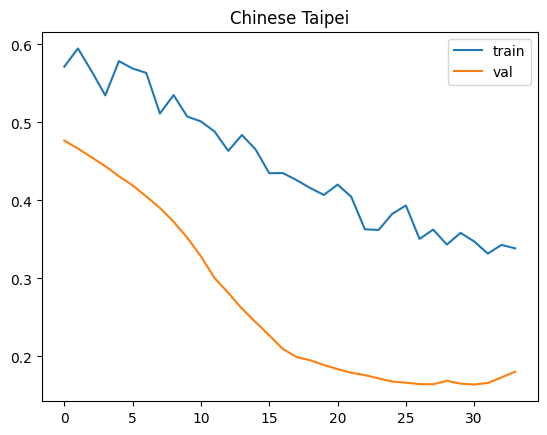

Hong Kong SAR
Epoch 0: train loss 0.7047, val loss 1.2777, time 0.0852
Epoch 1: train loss 0.6345, val loss 1.2598, time 0.0733
Epoch 2: train loss 0.6850, val loss 1.2331, time 0.0735
Epoch 3: train loss 0.6119, val loss 1.2043, time 0.0754
Epoch 4: train loss 0.6478, val loss 1.1622, time 0.0744
Epoch 5: train loss 0.5637, val loss 1.1145, time 0.0749
Epoch 6: train loss 0.5662, val loss 1.0519, time 0.0758
Epoch 7: train loss 0.5107, val loss 0.9694, time 0.0742
Epoch 8: train loss 0.5292, val loss 0.8719, time 0.0735
Epoch 9: train loss 0.4940, val loss 0.7761, time 0.0738
Epoch 10: train loss 0.4002, val loss 0.6556, time 0.0753
Epoch 11: train loss 0.3916, val loss 0.5514, time 0.0750
Epoch 12: train loss 0.3675, val loss 0.4604, time 0.0759
Epoch 13: train loss 0.3114, val loss 0.4094, time 0.0749
Epoch 14: train loss 0.2848, val loss 0.3741, time 0.0752
Epoch 15: train loss 0.2503, val loss 0.3540, time 0.0772
Epoch 16: train loss 0.3025, val loss 0.3498, time 0.0736
Epoch 17: 

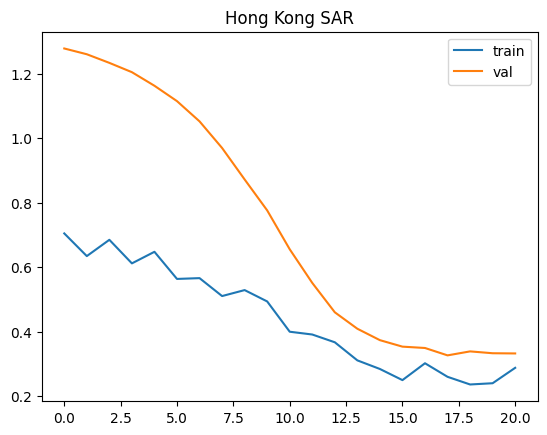

Japan
Epoch 0: train loss 0.7047, val loss 2.0884, time 0.0959
Epoch 1: train loss 0.6816, val loss 2.0746, time 0.0849
Epoch 2: train loss 0.6851, val loss 2.0567, time 0.0833
Epoch 3: train loss 0.6690, val loss 2.0353, time 0.0837
Epoch 4: train loss 0.6743, val loss 2.0086, time 0.0848
Epoch 5: train loss 0.6505, val loss 1.9772, time 0.0841
Epoch 6: train loss 0.6338, val loss 1.9382, time 0.0848
Epoch 7: train loss 0.5995, val loss 1.8954, time 0.0848
Epoch 8: train loss 0.5857, val loss 1.8438, time 0.0820
Epoch 9: train loss 0.5444, val loss 1.7904, time 0.0838
Epoch 10: train loss 0.5287, val loss 1.7344, time 0.0849
Epoch 11: train loss 0.4943, val loss 1.6763, time 0.0851
Epoch 12: train loss 0.4733, val loss 1.6114, time 0.0833
Epoch 13: train loss 0.4549, val loss 1.5477, time 0.0834
Epoch 14: train loss 0.4235, val loss 1.4818, time 0.0841
Epoch 15: train loss 0.4070, val loss 1.4207, time 0.0840
Epoch 16: train loss 0.3943, val loss 1.3512, time 0.0844
Epoch 17: train lo

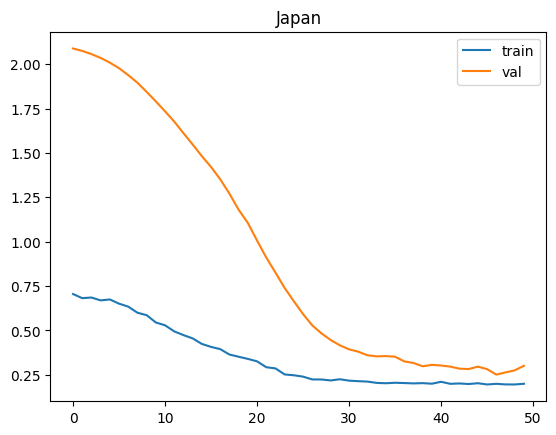

Korea (ROK)
Epoch 0: train loss 0.7462, val loss 1.4093, time 0.0934
Epoch 1: train loss 0.7897, val loss 1.3883, time 0.0809
Epoch 2: train loss 0.7365, val loss 1.3666, time 0.0801
Epoch 3: train loss 0.7327, val loss 1.3408, time 0.0795
Epoch 4: train loss 0.6978, val loss 1.3095, time 0.0798
Epoch 5: train loss 0.7132, val loss 1.2660, time 0.0799
Epoch 6: train loss 0.6620, val loss 1.2103, time 0.0825
Epoch 7: train loss 0.6385, val loss 1.1381, time 0.0802
Epoch 8: train loss 0.6097, val loss 1.0401, time 0.0797
Epoch 9: train loss 0.5338, val loss 0.9398, time 0.0794
Epoch 10: train loss 0.4832, val loss 0.8380, time 0.0810
Epoch 11: train loss 0.4342, val loss 0.7359, time 0.0803
Epoch 12: train loss 0.3867, val loss 0.6512, time 0.0815
Epoch 13: train loss 0.3591, val loss 0.5840, time 0.0815
Epoch 14: train loss 0.3314, val loss 0.5107, time 0.0800
Epoch 15: train loss 0.3123, val loss 0.4489, time 0.0805
Epoch 16: train loss 0.3021, val loss 0.3922, time 0.0818
Epoch 17: tr

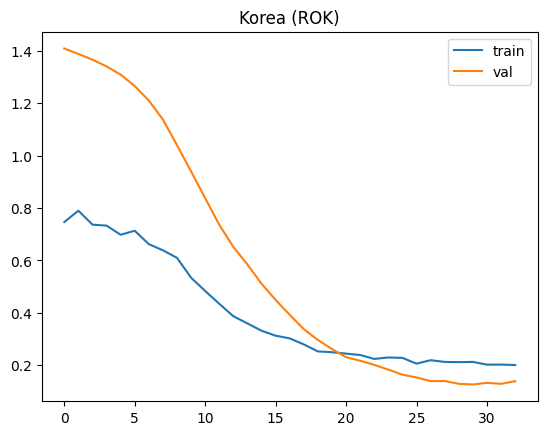

Macao, China
Epoch 0: train loss 0.5872, val loss 1.2153, time 0.0896
Epoch 1: train loss 0.6214, val loss 1.2012, time 0.0788
Epoch 2: train loss 0.5616, val loss 1.1860, time 0.0784
Epoch 3: train loss 0.6091, val loss 1.1649, time 0.0780
Epoch 4: train loss 0.5580, val loss 1.1435, time 0.0769
Epoch 5: train loss 0.5538, val loss 1.1159, time 0.0775
Epoch 6: train loss 0.5122, val loss 1.0872, time 0.0772
Epoch 7: train loss 0.5274, val loss 1.0477, time 0.0766
Epoch 8: train loss 0.5061, val loss 1.0032, time 0.0771
Epoch 9: train loss 0.4989, val loss 0.9485, time 0.0773
Epoch 10: train loss 0.4772, val loss 0.8915, time 0.0779
Epoch 11: train loss 0.4294, val loss 0.8240, time 0.0782
Epoch 12: train loss 0.4295, val loss 0.7536, time 0.0786
Epoch 13: train loss 0.3773, val loss 0.6929, time 0.0787
Epoch 14: train loss 0.3702, val loss 0.6332, time 0.0781
Epoch 15: train loss 0.3341, val loss 0.6017, time 0.0782
Epoch 16: train loss 0.3094, val loss 0.5537, time 0.0784
Epoch 17: t

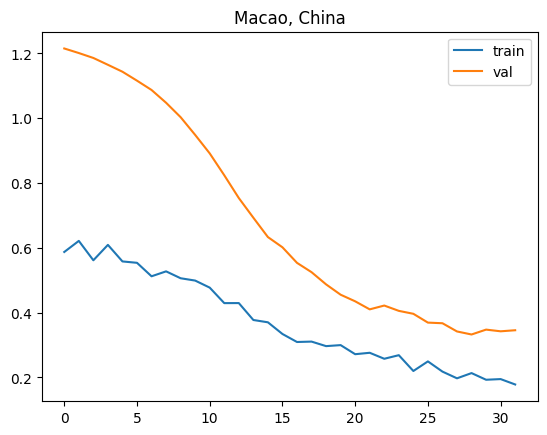

Maldives
Epoch 0: train loss 0.7693, val loss 0.9946, time 0.0920
Epoch 1: train loss 0.7758, val loss 0.9794, time 0.0808
Epoch 2: train loss 0.7773, val loss 0.9584, time 0.0792
Epoch 3: train loss 0.7338, val loss 0.9317, time 0.0799
Epoch 4: train loss 0.7306, val loss 0.8975, time 0.0808
Epoch 5: train loss 0.6916, val loss 0.8541, time 0.0800
Epoch 6: train loss 0.6768, val loss 0.7963, time 0.0808
Epoch 7: train loss 0.6396, val loss 0.7313, time 0.0801
Epoch 8: train loss 0.5749, val loss 0.6583, time 0.0797
Epoch 9: train loss 0.5278, val loss 0.5689, time 0.0814
Epoch 10: train loss 0.4748, val loss 0.4720, time 0.0807
Epoch 11: train loss 0.4300, val loss 0.3880, time 0.0808
Epoch 12: train loss 0.3823, val loss 0.3241, time 0.0814
Epoch 13: train loss 0.3560, val loss 0.2772, time 0.0809
Epoch 14: train loss 0.3353, val loss 0.2448, time 0.0798
Epoch 15: train loss 0.3197, val loss 0.2208, time 0.0828
Epoch 16: train loss 0.3098, val loss 0.1981, time 0.0822
Epoch 17: train

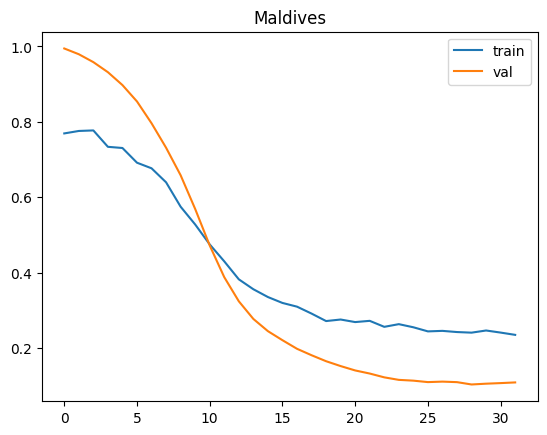

Cambodia
Epoch 0: train loss 0.7385, val loss 1.9029, time 0.0678
Epoch 1: train loss 0.7139, val loss 1.8794, time 0.0594
Epoch 2: train loss 0.6839, val loss 1.8578, time 0.0613
Epoch 3: train loss 0.6819, val loss 1.8286, time 0.0599
Epoch 4: train loss 0.6832, val loss 1.7937, time 0.0602
Epoch 5: train loss 0.6660, val loss 1.7562, time 0.0594
Epoch 6: train loss 0.6186, val loss 1.7142, time 0.0600
Epoch 7: train loss 0.6008, val loss 1.6670, time 0.0591
Epoch 8: train loss 0.5807, val loss 1.6168, time 0.0593
Epoch 9: train loss 0.5495, val loss 1.5566, time 0.0595
Epoch 10: train loss 0.5344, val loss 1.4909, time 0.0604
Epoch 11: train loss 0.4817, val loss 1.4235, time 0.0599
Epoch 12: train loss 0.4715, val loss 1.3544, time 0.0618
Epoch 13: train loss 0.4153, val loss 1.2941, time 0.0602
Epoch 14: train loss 0.4073, val loss 1.2372, time 0.0606
Epoch 15: train loss 0.3718, val loss 1.1875, time 0.0605
Epoch 16: train loss 0.3505, val loss 1.1423, time 0.0610
Epoch 17: train

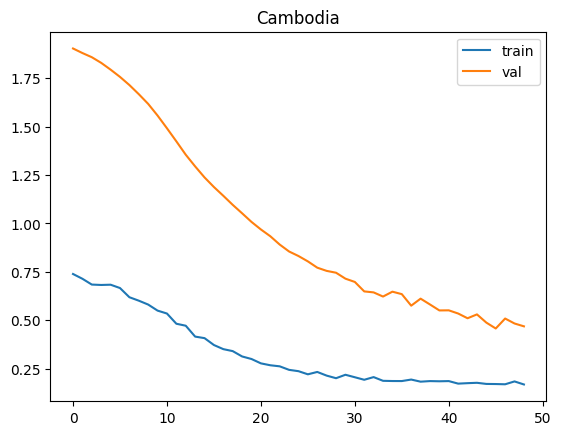

Indonesia
Epoch 0: train loss 0.7341, val loss 1.1544, time 0.0182
Epoch 1: train loss 0.7358, val loss 1.1480, time 0.0160
Epoch 2: train loss 0.7319, val loss 1.1425, time 0.0156
Epoch 3: train loss 0.7239, val loss 1.1369, time 0.0163
Epoch 4: train loss 0.7127, val loss 1.1316, time 0.0156
Epoch 5: train loss 0.7154, val loss 1.1258, time 0.0158
Epoch 6: train loss 0.7201, val loss 1.1199, time 0.0156
Epoch 7: train loss 0.7081, val loss 1.1131, time 0.0154
Epoch 8: train loss 0.7137, val loss 1.1072, time 0.0155
Epoch 9: train loss 0.7012, val loss 1.1011, time 0.0155
Epoch 10: train loss 0.7031, val loss 1.0939, time 0.0160
Epoch 11: train loss 0.6934, val loss 1.0862, time 0.0154
Epoch 12: train loss 0.6939, val loss 1.0791, time 0.0155
Epoch 13: train loss 0.6914, val loss 1.0713, time 0.0154
Epoch 14: train loss 0.6871, val loss 1.0639, time 0.0156
Epoch 15: train loss 0.6929, val loss 1.0559, time 0.0153
Epoch 16: train loss 0.6948, val loss 1.0481, time 0.0175
Epoch 17: trai

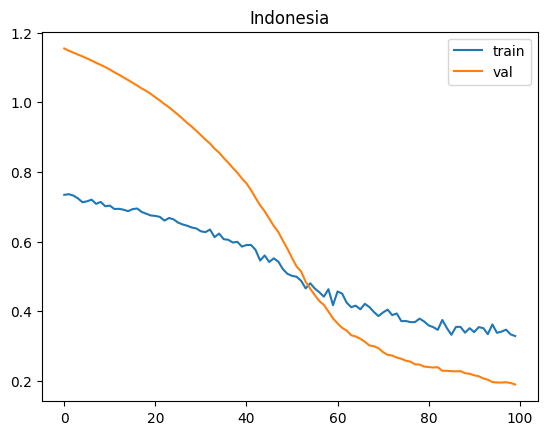

Singapore
Epoch 0: train loss 0.6501, val loss 1.5578, time 0.0745
Epoch 1: train loss 0.6396, val loss 1.5433, time 0.0656
Epoch 2: train loss 0.6477, val loss 1.5258, time 0.0650
Epoch 3: train loss 0.6200, val loss 1.5066, time 0.0652
Epoch 4: train loss 0.6150, val loss 1.4817, time 0.0652
Epoch 5: train loss 0.6141, val loss 1.4510, time 0.0659
Epoch 6: train loss 0.5922, val loss 1.4172, time 0.0641
Epoch 7: train loss 0.5726, val loss 1.3781, time 0.0636
Epoch 8: train loss 0.5540, val loss 1.3269, time 0.0657
Epoch 9: train loss 0.5334, val loss 1.2629, time 0.0655
Epoch 10: train loss 0.5027, val loss 1.1957, time 0.0661
Epoch 11: train loss 0.4703, val loss 1.1247, time 0.0653
Epoch 12: train loss 0.4530, val loss 1.0590, time 0.0667
Epoch 13: train loss 0.4325, val loss 0.9959, time 0.0647
Epoch 14: train loss 0.4071, val loss 0.9341, time 0.0629
Epoch 15: train loss 0.3808, val loss 0.8674, time 0.0644
Epoch 16: train loss 0.3717, val loss 0.8079, time 0.0656
Epoch 17: trai

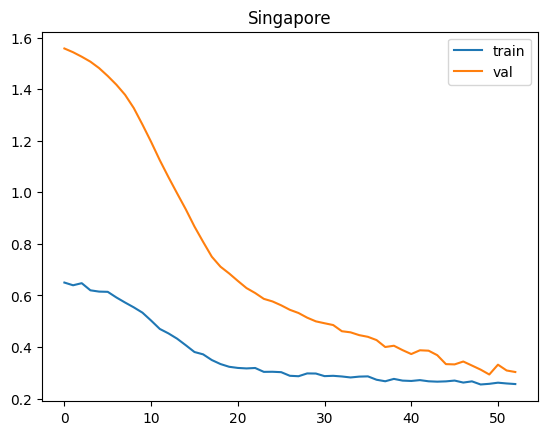

New Zealand
Epoch 0: train loss 0.7844, val loss 1.4604, time 0.0723
Epoch 1: train loss 0.7835, val loss 1.4451, time 0.0650
Epoch 2: train loss 0.7610, val loss 1.4293, time 0.0631
Epoch 3: train loss 0.7537, val loss 1.4113, time 0.0621
Epoch 4: train loss 0.7482, val loss 1.3904, time 0.0631
Epoch 5: train loss 0.7364, val loss 1.3661, time 0.0633
Epoch 6: train loss 0.7403, val loss 1.3334, time 0.0626
Epoch 7: train loss 0.7134, val loss 1.2934, time 0.0628
Epoch 8: train loss 0.6872, val loss 1.2463, time 0.0643
Epoch 9: train loss 0.6683, val loss 1.1933, time 0.0638
Epoch 10: train loss 0.6339, val loss 1.1384, time 0.0625
Epoch 11: train loss 0.6080, val loss 1.0785, time 0.0622
Epoch 12: train loss 0.5642, val loss 1.0186, time 0.0630
Epoch 13: train loss 0.5375, val loss 0.9583, time 0.0629
Epoch 14: train loss 0.5145, val loss 0.9006, time 0.0633
Epoch 15: train loss 0.4952, val loss 0.8383, time 0.0632
Epoch 16: train loss 0.4653, val loss 0.7792, time 0.0647
Epoch 17: tr

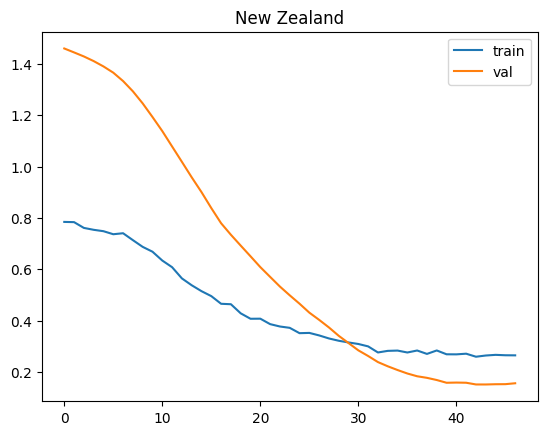

USA
Epoch 0: train loss 0.8083, val loss 1.3209, time 0.0832
Epoch 1: train loss 0.9553, val loss 1.3104, time 0.0738
Epoch 2: train loss 0.8225, val loss 1.2914, time 0.0735
Epoch 3: train loss 0.9156, val loss 1.2687, time 0.0739
Epoch 4: train loss 0.9791, val loss 1.2344, time 0.0740
Epoch 5: train loss 0.9070, val loss 1.2189, time 0.0733
Epoch 6: train loss 0.6841, val loss 1.1983, time 0.0728
Epoch 7: train loss 0.7673, val loss 1.1737, time 0.0721
Epoch 8: train loss 0.8776, val loss 1.1454, time 0.0723
Epoch 9: train loss 0.7989, val loss 1.1051, time 0.0736
Epoch 10: train loss 0.7646, val loss 1.0690, time 0.0749
Epoch 11: train loss 0.8576, val loss 1.0340, time 0.0725
Epoch 12: train loss 0.5482, val loss 0.9958, time 0.0744
Epoch 13: train loss 0.5113, val loss 0.9532, time 0.0745
Epoch 14: train loss 0.4869, val loss 0.9045, time 0.0726
Epoch 15: train loss 0.5405, val loss 0.8425, time 0.0730
Epoch 16: train loss 0.4307, val loss 0.7725, time 0.0741
Epoch 17: train loss

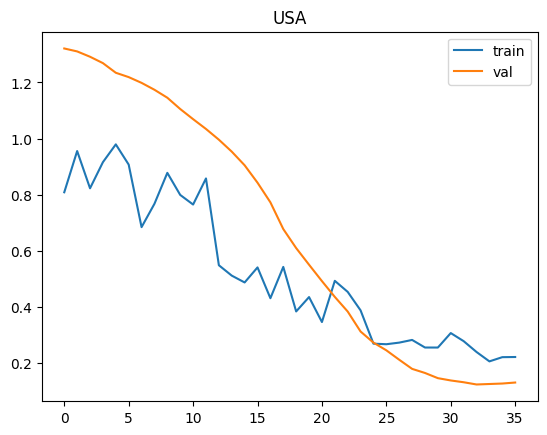

Thailand
Epoch 0: train loss 0.8272, val loss 1.9411, time 0.1050
Epoch 1: train loss 0.8177, val loss 1.9192, time 0.0911
Epoch 2: train loss 0.8013, val loss 1.8922, time 0.0912
Epoch 3: train loss 0.7812, val loss 1.8618, time 0.0932
Epoch 4: train loss 0.7598, val loss 1.8291, time 0.0935
Epoch 5: train loss 0.7366, val loss 1.7943, time 0.0921
Epoch 6: train loss 0.7073, val loss 1.7570, time 0.0916
Epoch 7: train loss 0.6809, val loss 1.7174, time 0.0910
Epoch 8: train loss 0.6487, val loss 1.6734, time 0.0915
Epoch 9: train loss 0.6094, val loss 1.6223, time 0.0927
Epoch 10: train loss 0.5792, val loss 1.5615, time 0.0933
Epoch 11: train loss 0.5510, val loss 1.4918, time 0.0928
Epoch 12: train loss 0.5176, val loss 1.4091, time 0.0952
Epoch 13: train loss 0.4854, val loss 1.3176, time 0.0920
Epoch 14: train loss 0.4636, val loss 1.2254, time 0.0920
Epoch 15: train loss 0.4259, val loss 1.1337, time 0.0918
Epoch 16: train loss 0.4037, val loss 1.0407, time 0.0918
Epoch 17: train

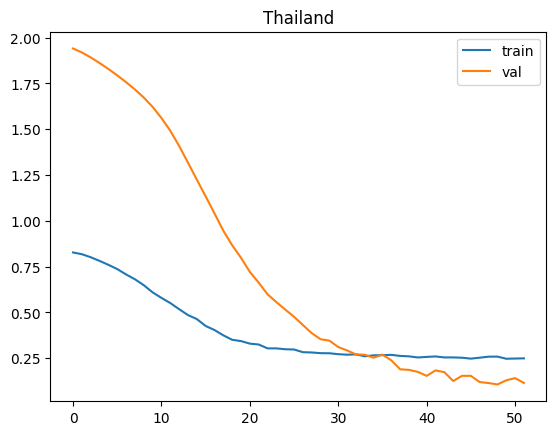

Turkey
Epoch 0: train loss 0.6566, val loss 1.8324, time 0.0854
Epoch 1: train loss 0.7101, val loss 1.8105, time 0.0754
Epoch 2: train loss 0.6832, val loss 1.7827, time 0.0734
Epoch 3: train loss 0.6953, val loss 1.7526, time 0.0753
Epoch 4: train loss 0.6562, val loss 1.7118, time 0.0750
Epoch 5: train loss 0.5948, val loss 1.6683, time 0.0757
Epoch 6: train loss 0.6299, val loss 1.6057, time 0.0765
Epoch 7: train loss 0.6071, val loss 1.5255, time 0.0753
Epoch 8: train loss 0.5905, val loss 1.4373, time 0.0740
Epoch 9: train loss 0.5010, val loss 1.3481, time 0.0752
Epoch 10: train loss 0.4820, val loss 1.2584, time 0.0758
Epoch 11: train loss 0.4349, val loss 1.1683, time 0.0743
Epoch 12: train loss 0.3998, val loss 1.0947, time 0.0772
Epoch 13: train loss 0.3667, val loss 1.0352, time 0.0777
Epoch 14: train loss 0.3778, val loss 0.9636, time 0.0762
Epoch 15: train loss 0.3065, val loss 0.9256, time 0.0757
Epoch 16: train loss 0.3168, val loss 0.8759, time 0.0771
Epoch 17: train l

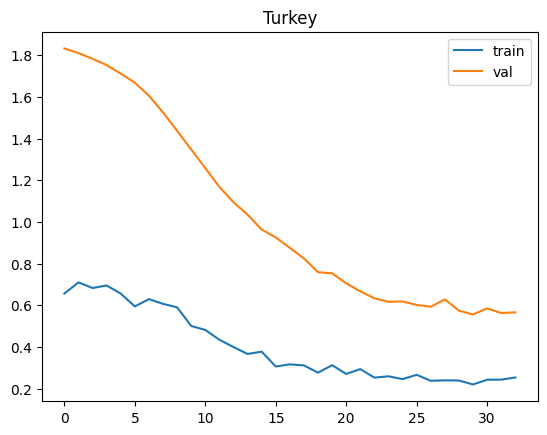

Australia
Epoch 0: train loss 0.7716, val loss 1.5107, time 0.1362
Epoch 1: train loss 0.7949, val loss 1.4898, time 0.1196
Epoch 2: train loss 0.7332, val loss 1.4642, time 0.1223
Epoch 3: train loss 0.7646, val loss 1.4320, time 0.1197
Epoch 4: train loss 0.6976, val loss 1.3964, time 0.1202
Epoch 5: train loss 0.6682, val loss 1.3433, time 0.1199
Epoch 6: train loss 0.6637, val loss 1.2718, time 0.1197
Epoch 7: train loss 0.6390, val loss 1.1531, time 0.1174
Epoch 8: train loss 0.5091, val loss 1.0179, time 0.1197
Epoch 9: train loss 0.4652, val loss 0.8684, time 0.1207
Epoch 10: train loss 0.4027, val loss 0.7670, time 0.1373
Epoch 11: train loss 0.3867, val loss 0.6943, time 0.1199
Epoch 12: train loss 0.3270, val loss 0.6155, time 0.1248
Epoch 13: train loss 0.3139, val loss 0.5523, time 0.1222
Epoch 14: train loss 0.2866, val loss 0.5116, time 0.1240
Epoch 15: train loss 0.2564, val loss 0.4416, time 0.1228
Epoch 16: train loss 0.2655, val loss 0.3814, time 0.1244
Epoch 17: trai

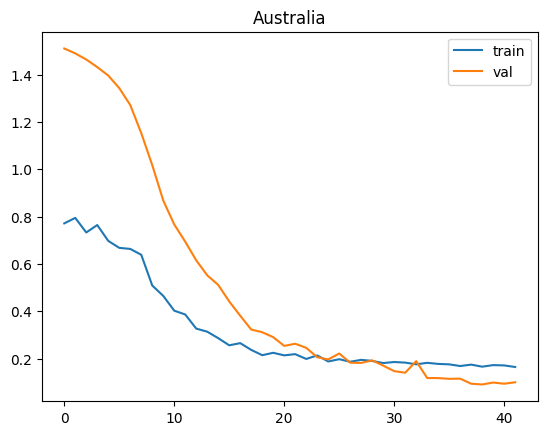

Hawaii
Epoch 0: train loss 0.7335, val loss 0.8171, time 0.0930
Epoch 1: train loss 0.7147, val loss 0.7811, time 0.0977
Epoch 2: train loss 0.6940, val loss 0.7439, time 0.0793
Epoch 3: train loss 0.6820, val loss 0.7049, time 0.0811
Epoch 4: train loss 0.6532, val loss 0.6586, time 0.0822
Epoch 5: train loss 0.6348, val loss 0.6020, time 0.0815
Epoch 6: train loss 0.5917, val loss 0.5348, time 0.0811
Epoch 7: train loss 0.5741, val loss 0.4528, time 0.0819
Epoch 8: train loss 0.5143, val loss 0.3829, time 0.0801
Epoch 9: train loss 0.4724, val loss 0.3748, time 0.0811
Epoch 10: train loss 0.4273, val loss 0.3639, time 0.0829
Epoch 11: train loss 0.3976, val loss 0.3386, time 0.0805
Epoch 12: train loss 0.3869, val loss 0.3125, time 0.0794
Epoch 13: train loss 0.3519, val loss 0.3188, time 0.0819
Epoch 14: train loss 0.3344, val loss 0.3421, time 0.0799
Epoch 15: train loss 0.3359, val loss 0.3932, time 0.0799
Early stopping as no improvement in val loss


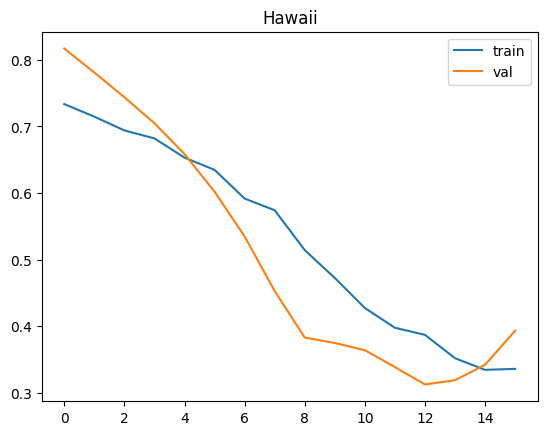

Austria
Epoch 0: train loss 0.8033, val loss 1.6895, time 0.0659
Epoch 1: train loss 0.7978, val loss 1.6775, time 0.0584
Epoch 2: train loss 0.7935, val loss 1.6639, time 0.0591
Epoch 3: train loss 0.7924, val loss 1.6466, time 0.0581
Epoch 4: train loss 0.7555, val loss 1.6282, time 0.0587
Epoch 5: train loss 0.7627, val loss 1.6060, time 0.0593
Epoch 6: train loss 0.7216, val loss 1.5807, time 0.0592
Epoch 7: train loss 0.7372, val loss 1.5474, time 0.0575
Epoch 8: train loss 0.7007, val loss 1.5079, time 0.0572
Epoch 9: train loss 0.6748, val loss 1.4641, time 0.0569
Epoch 10: train loss 0.6348, val loss 1.4140, time 0.0590
Epoch 11: train loss 0.5733, val loss 1.3611, time 0.0574
Epoch 12: train loss 0.5407, val loss 1.3039, time 0.0574
Epoch 13: train loss 0.4937, val loss 1.2440, time 0.0595
Epoch 14: train loss 0.4580, val loss 1.1752, time 0.0594
Epoch 15: train loss 0.4145, val loss 1.0981, time 0.0581
Epoch 16: train loss 0.3918, val loss 1.0361, time 0.0577
Epoch 17: train 

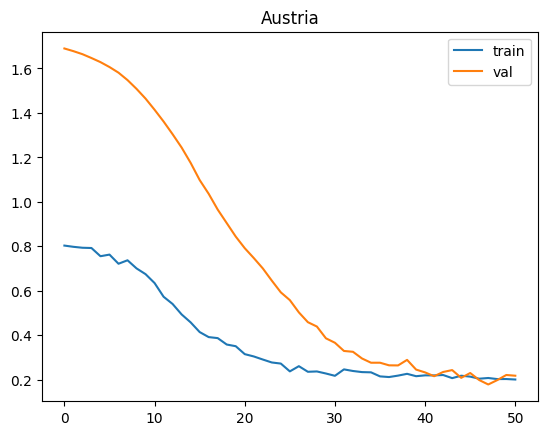

Czech
Epoch 0: train loss 0.7369, val loss 1.5907, time 0.0230
Epoch 1: train loss 0.7360, val loss 1.5839, time 0.0197
Epoch 2: train loss 0.7226, val loss 1.5778, time 0.0197
Epoch 3: train loss 0.7237, val loss 1.5722, time 0.0194
Epoch 4: train loss 0.7207, val loss 1.5664, time 0.0194
Epoch 5: train loss 0.7117, val loss 1.5606, time 0.0194
Epoch 6: train loss 0.7078, val loss 1.5545, time 0.0197
Epoch 7: train loss 0.7122, val loss 1.5484, time 0.0196
Epoch 8: train loss 0.7064, val loss 1.5421, time 0.0204
Epoch 9: train loss 0.7026, val loss 1.5355, time 0.0195
Epoch 10: train loss 0.6944, val loss 1.5289, time 0.0192
Epoch 11: train loss 0.6904, val loss 1.5217, time 0.0195
Epoch 12: train loss 0.6890, val loss 1.5146, time 0.0195
Epoch 13: train loss 0.6821, val loss 1.5074, time 0.0208
Epoch 14: train loss 0.6792, val loss 1.5001, time 0.0192
Epoch 15: train loss 0.6789, val loss 1.4925, time 0.0191
Epoch 16: train loss 0.6687, val loss 1.4846, time 0.0191
Epoch 17: train lo

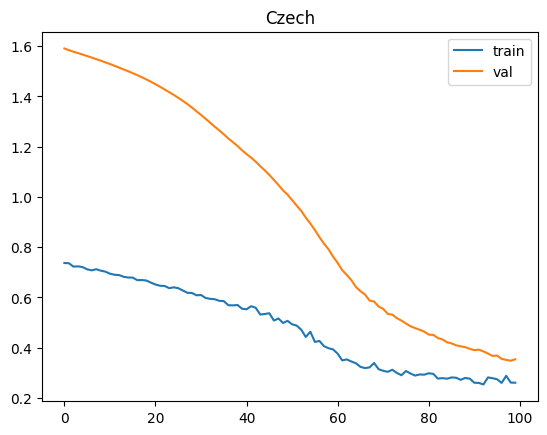

In [597]:
best_param = ({'seq_len': 24, 'batch_size': 64}, 
              {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'nadam', 'lr': 0.001})

rnn_sep_pred, rnn_sep_gt = [], []
for i, country in enumerate(country_list):
    print(country)
    seq_train_x, seq_train_y, seq_test_x, seq_test_y = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=12, test_size=1)

    model = ForecastModel(**best_param[1], input_size=18, output_size=12, conditional_labels=country_list)
    optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
    criterion = nn.L1Loss()

    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
    # train_dataset.initialize_states()
    test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
    # test_dataset.set_initial_states(train_dataset.get_initial_states())
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=100)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(country)
    plt.legend()
    plt.show()
    
    rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

    _, ds_x, ds_y = test_dataset.__getitem__(0)
    rnn_sep_pred.append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_sep_gt = np.concatenate(rnn_sep_gt)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

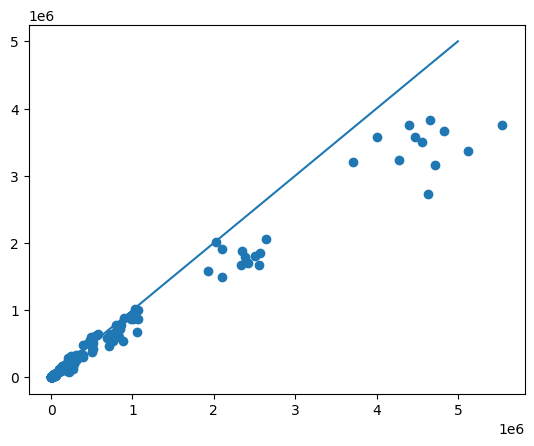

In [598]:
plt.scatter(all_y, rnn_sep_pred)
plt.plot((0, 5000000), (0, 5000000))

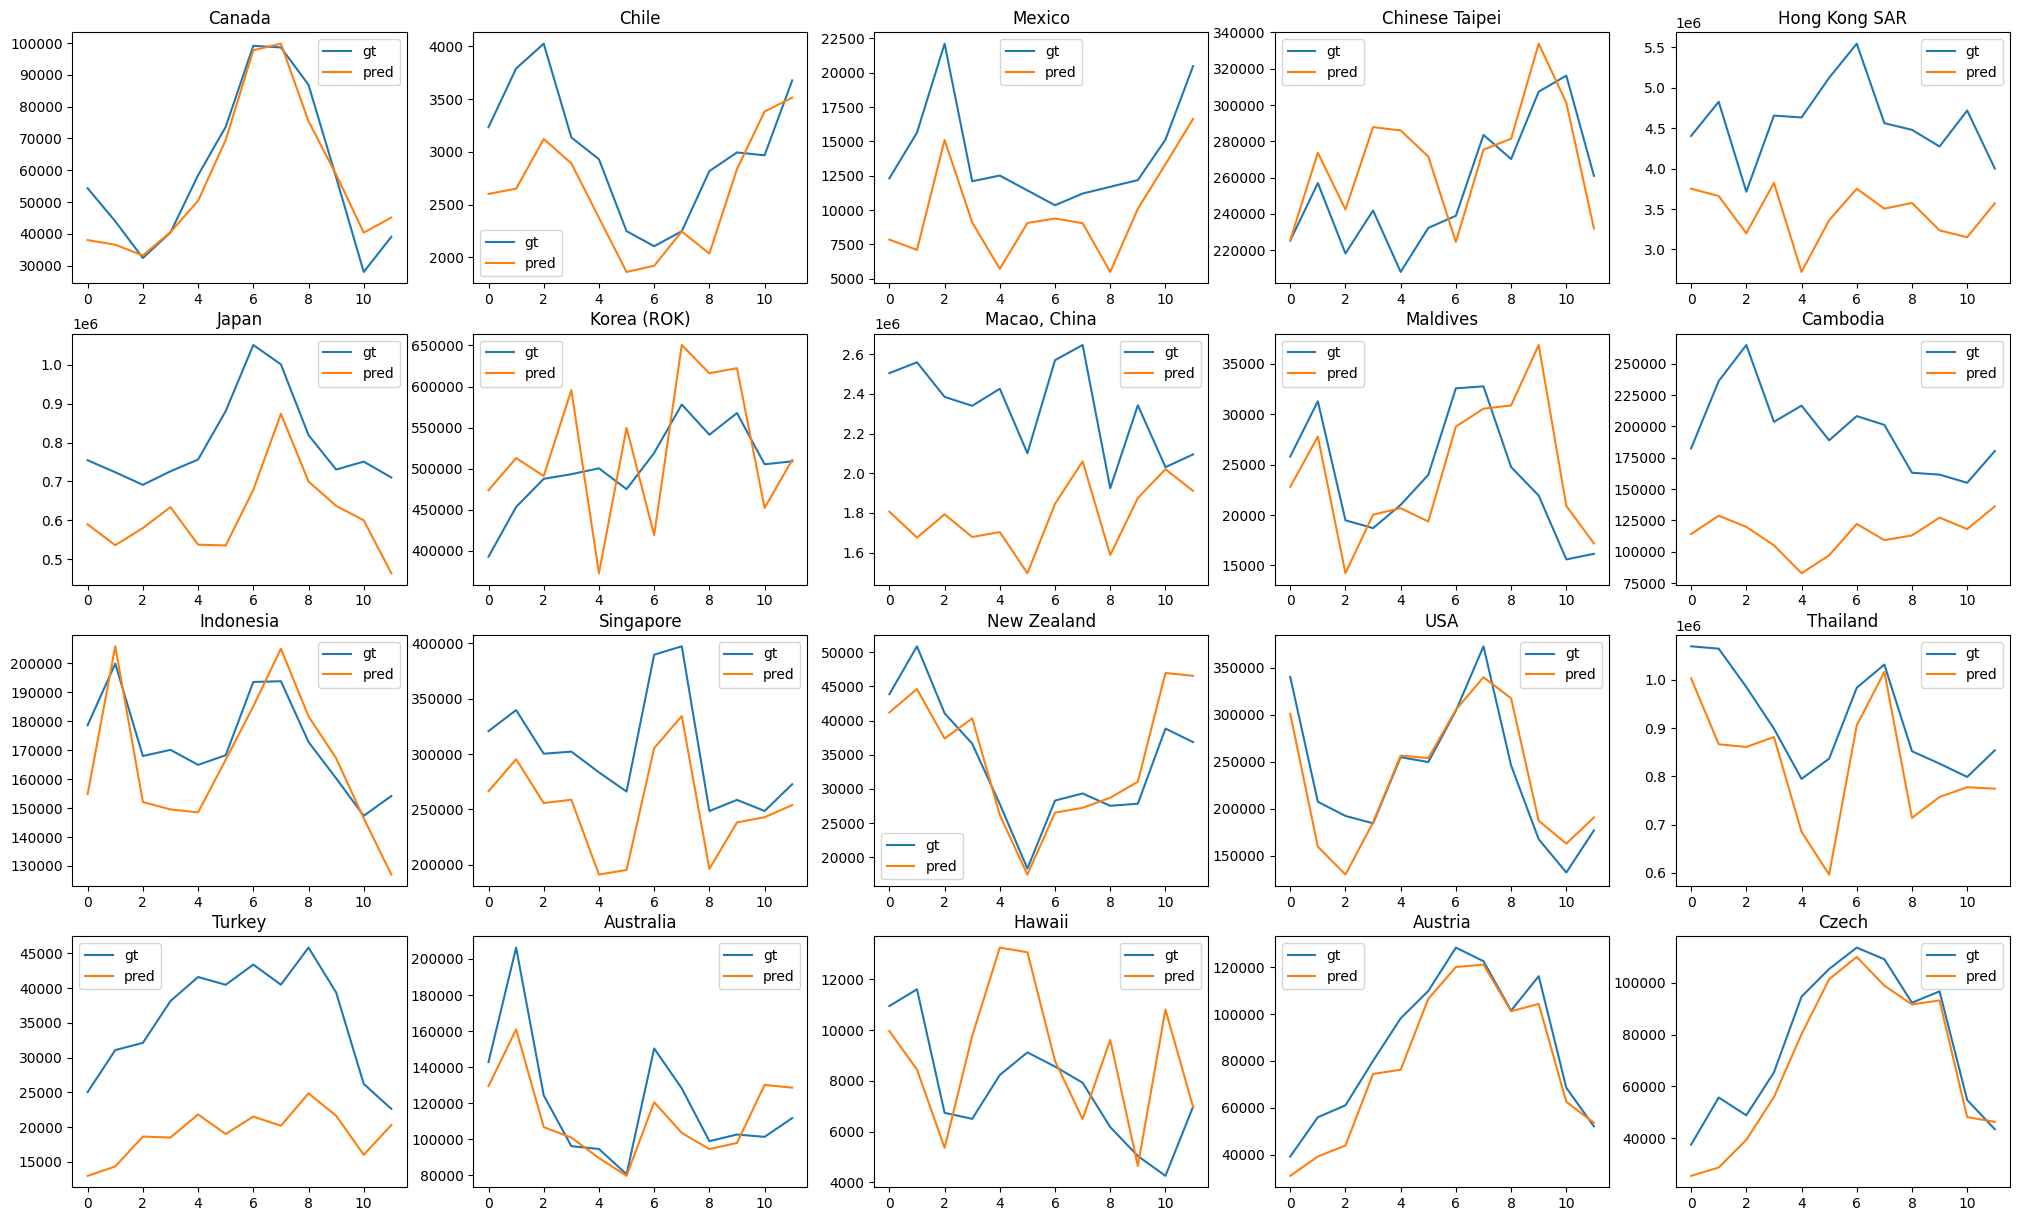

In [599]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_sep_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [600]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
rnn_sep_mae = mean_absolute_error(all_y, rnn_sep_pred)
rnn_sep_mape = mean_absolute_percentage_error(all_y, rnn_sep_pred)
print(f'RNN Sep RMSE: {rnn_sep_rmse:.5f}\nRNN Sep R2: {rnn_sep_r2:.5f}\nRNN Sep MAE: {rnn_sep_mae:.5f}\nRNN Sep MAPE: {rnn_sep_mape:.5f}')

RNN Sep RMSE: 312481.53879
RNN Sep R2: 0.91486
RNN Sep MAE: 114537.31167
RNN Sep MAPE: 0.19341
